<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg" />

# Project: Predicting the price of a car based on its characteristics

#### Project done by Eugenia Voytik, October 2021

Let's imagine that there is a company that sells used cars in Moscow. The main task of the company and its managers is to find bargains as quickly as possible (to put it simply, to buy below the market and sell above the market price).

The company's management needs to create a model that will predict the value of the car based on its characteristics.

If this model works well, you will be able to quickly identify bargains (when the price desired by the seller is lower than the predicted market price). This will greatly speed up your managers' work and increase your company's profits.

Problem: Historically, the company has not collected data from the beginning. There is only a small dataset with a short period of sales history, which is clearly insufficient to train the model. We will use it for the test, the rest will have to be collected independently.

### Terms and Conditions:

- It is allowed to use external data, but its source must be public and accessible for all contestants (e.g. `auto.ru`);
- It is allowed to use any ML algorithms and libraries (except DL);
- Model quality metric: MAPE - Mean Absolute Percentage Error.

# 1. Install and import all necessary libraries, supplementary functions, setup

In [20]:
!pip install pandas-profiling CurrencyConverter hyperopt xgboost

In [21]:
# import common packages
import re
import sys
import itertools
import datetime
from tqdm.notebook import tqdm
import pandas_profiling
from currency_converter import CurrencyConverter
from datetime import datetime

# import visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

# import packages to work with the numeric, tabular data
import numpy as np 
import pandas as pd 

# import ML packages
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer

from catboost import CatBoostRegressor
# import xgboost as xgb

from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope

import warnings
warnings.filterwarnings("ignore")

In [22]:
print('Python:', sys.version.split('\n')[0])
print('Numpy:', np.__version__)

Python: 3.8.0 (default, Nov  6 2019, 15:49:01) 
Numpy: 1.21.2


In [23]:
# let's fix the package versions so that the experiments are reproducible:
!pip freeze > requirements.txt

In [24]:
# fix the RANDOM_SEED value so that the experiments are reproducible:
RANDOM_SEED = 42

Add functions to help with the analysis.

In [25]:
def mape(
    y_true: np.ndarray, 
    y_pred: np.ndarray
):
    """
    Calculate the mean absolute percentage error (MAPE).
    
    The mean absolute percentage error (MAPE) is a measure of how accurate a forecast system is. 
    It measures this accuracy as a percentage, and can be calculated as the average absolute 
    percent error for each time period minus actual values divided by actual values.
    """
    return np.mean(np.abs((y_pred-y_true)/y_true))


def print_df_differences(
    dfs_names: list, 
    dfs: list
):
    """
    Сompare datasets in pairs and print unique columns for each dataset and the type of the common 
    columns, if different.
    
    This function takes a list of dataframe names (dfs_names) and the dataframes themselves (dfs) 
    and, by comparing them against each other, display a list of columns that are present in one dataset 
    and absent in the other. It also prints the type of columns the two datasets have in common, if they 
    are different.
    """
    for df in itertools.permutations(zip(dfs_names, dfs)):
        print(f"\nColumns that are present in -{df[0][0]}- dataset and missing in -{df[1][0]}- dataset:")
        print(set(df[0][1].columns).difference(df[1][1].columns))
        for col in set(df[0][1].columns).intersection(df[1][1].columns):
            if df[0][1][col].dtypes != df[1][1][col].dtypes:
                print(f"The common {col} column: {df[0][1][col].dtypes} in -{df[0][0]}- dataset and {df[1][1][col].dtypes} in -{df[1][0]}- dataset")
                
def convert_engineDisplacement_to_float(
    row: str
):
    """
    Convert the engineDisplacement column values to floats.
    """
    extracted_value = re.findall('\d\.\d', str(row))
    if extracted_value:
        return float(extracted_value[0])
    return None

def convert_owners_to_float(
    value: str
):
    """
    Convert the owners column values to floats.
    """
    if isinstance(value, str):
        return float(value.replace('\xa0', ' ').split()[0])
    return value

def convert_vehicleTransmission_to_categ(
    value: str
):
    """
    Convert the vehicleTransmission column values to 2 categories.
    """
    if isinstance(value, str):
        if value in ['MECHANICAL', 'механическая']:
            return 'mechanical'
        else:
            return 'automatic'
    return value

def convert_vehicle_licence_to_categ(
    value: str
):
    """
    Convert the vehicle_licence column values to 2 categories.
    """
    if isinstance(value, str):
        if value in ['Оригинал', 'ORIGINAL']:
            return 'original'
        else:
            return 'duplicate'
    return value

def convert_enginePower_to_float(
    value: str
):
    """
    Convert the enginePower column values to floats.
    """
    if isinstance(value, str):
        if value == 'undefined N12':
            return None
        else:
            return float(value.replace(' N12', ''))
    return value

def fill_model_name_with_name(
    all_model_names: list, 
    name: str
):
    """
    Fill the missing values of the model_name feature with the data from name column.
    """
    name = name.lower()
    if isinstance(name, str):
        if "RS Q8".lower() in name:
            return 'Q8'
        elif "QX55".lower() in name:
            return "QX55"
        try:
            value = name.split()
        except:
            return None
        if value[1] in all_model_names:
            return value[1]
        try:
            joined_value = "_".join([value[1], value[2]])
        except IndexError:
            return None
        if joined_value in all_model_names:
            return f"{value[1]}_{value[2]}"
        elif joined_value.replace('_', ' ') in all_model_names:
            return f"{value[1]} {value[2]}"
    return None

def fill_steering_wheel(
    brand: str, 
    model: str, 
    right_wheel_dict: dict
):
    """
    Fill the missing values of the steering_wheel feature with the data about right wheels brand's models.
    """
    try:
        if model in right_wheel_dict[brand]:
            return 'right'
        else:
            return 'left'
    except:
        return 'left'
    
def fill_driving_gear(
    brand: str, 
    model_name: str, 
    df: pd.DataFrame
):
    """
    Fill the missing values of the driving_gear feature with the most popular driving gear in the brand's models.
    """
    sliced_df = df[(df.brand == brand) & (df.model_name == model_name)]
    try:
        return sliced_df.driving_gear.values[0]
    except:
        # the most popular driving_gear in the combined dataset: combined_df.driving_gear.value_counts().index[0]
        return 'полный'     
    
def vis_num_feature(
    data: pd.DataFrame, 
    column: str,
    target_column: str,
    query_for_slicing: str
):
    """
    Show the EDA plots for numerical data.
    """
    plt.style.use('seaborn-paper')
    fig, ax = plt.subplots(2, 3, figsize=(15, 9))
    data[column].plot.hist(ax=ax[0][0])
    ax[0][0].set_title(column)
    sns.boxplot(data=data, y=column, ax=ax[0][1], orient='v')
    sns.scatterplot(data=data.query(query_for_slicing), x=column, y=target_column, ax=ax[0][2])
    np.log2(data[column] + 1).plot.hist(ax=ax[1][0])
    ax[1][0].set_title(f'log2 transformed {column}')
    sns.boxplot(y=np.log2(data[column]), ax=ax[1][1], orient='v')
    plt.show()
    
def calculate_stat_outliers(
    data_initial: pd.DataFrame,
    column: str,
    log: bool = False
):
    """
    Calculate the outliers for the numerical features using IQR and q1/q3 values.
    """
    data = data_initial.copy()
    if log:
        data[column] = np.log2(data[column] + 1)
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    IQR = q3 - q1
    mask25 = q1 - IQR * 1.5                   
    mask75 = q3 + IQR * 1.5

    values = {}
    values['borders'] = mask25, mask75
    values['# outliers'] = data[(data[column] < mask25)].shape[0], data[data[column] > mask75].shape[0]

    return pd.DataFrame.from_dict(data=values, orient='index', columns=['left', 'right'])

def show_boxplot(
    data: pd.DataFrame, 
    column: str, 
    target_column: str
):
    """
    Show the boxplot for the numerical feature.
    """
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y=target_column, 
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index)],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
    
def extract_autodealer(
    value: str
):
    """
    Extract the information from the Description column whether auto dealer published the ad.
    """
    if isinstance(value, str):
        auto_dealer = 'филиал_тест-драйв_менеджер_клиент_мегамолл_автокредит_ао_официальный дилер_ваш выбор'.split('_')
        for each in auto_dealer:
            if each in value:
                return 1
        if len(value) > 500:
            return 0
        return 0
    return None

## Current Setup

In [26]:
VERSION    = 4
DIR_TRAIN  = '../input/parsing-all-moscow-auto-ru-09-09-2020/' # connected an external dataset to the laptop
DIR_TRAIN_PARSED  = '../input/final-car-price-prediction-df-parsed-sep-2021/' # connected a parsed dataset from the page `auto.ru`
DIR_TEST   = '../input/sf-dst-car-price-prediction/'
VAL_SIZE= 0.20   # 20%
cols_to_remove = []

# 2. Data upload and preliminary analysis

In [27]:
!ls '../input'

ls: ../input: No such file or directory


In [28]:
# # for Kaggle
# train = pd.read_csv(DIR_TRAIN + 'all_auto_ru_09_09_2020.csv') 
# test = pd.read_csv(DIR_TEST + 'test.csv')
# sample_submission = pd.read_csv(DIR_TEST + 'sample_submission.csv')

# for Jupyter notebook
# to access the data in jupyter notebook you need to download all files 
# from the https://www.kaggle.com/eugeniavoytik/sf-dst-car-price-prediction-eda-ml/data?scriptVersionId=76635935
# and put them into data folder
train = pd.read_csv('Data/all_auto_ru_09_09_2020.csv')
test = pd.read_csv('Data/test.csv')
sample_submission = pd.read_csv('Data/sample_submission.csv')

In [29]:
train.head(2)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100


In [30]:
test.head(2)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

In [32]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

As we can already see, two datasets contain different information (columns). Let's extract the columns that present only in the test set and missing in the train set. 

In [33]:
set(test.columns).difference(train.columns)

{'car_url',
 'complectation_dict',
 'equipment_dict',
 'image',
 'model_info',
 'model_name',
 'parsing_unixtime',
 'priceCurrency',
 'sell_id',
 'super_gen',
 'vendor'}

So the test dataset contains more columns and the train dataset is relatively small. Therefore, it's important to parse the up-to-date training dataset for this project separately from `auto.ru`. You can find more information about parsing in [a separate notebook](https://github.com/EugeniaVoytik/Car_price_prediction/blob/main/%5BSF-DST%20Car%20Price%20Prediction%5D%20Data%20parsing.ipynb) on the GitHub.

## A brief summary of what has been done in the parsing phase:
1. In the first step, for all twelve car brands present in the test dataset all url links available on the `auto.ru` page were collected and saved to a file.
2. Second, for all available links I extracted all information that is present in the test dataset, except for two columns: model_info and vendor, whose information was not informative. I also included several additional columns that could potentially improve the model, such as `views`, `date_added`, `region`, `price`. 

The result dataset contains **34 features** and **130201** observations. 

## Import parsed data into a separate dataframe.

In [34]:
# # for Kaggle 
# train_parsed = pd.read_csv(DIR_TRAIN_PARSED + 'train_df_full_part1.csv')

# for Jupyter Notebook
# to access the data in jupyter notebook you need to download all files 
# from the https://www.kaggle.com/eugeniavoytik/sf-dst-car-price-prediction-eda-ml/data?scriptVersionId=76635935
# and put them into data folder
train_parsed = pd.read_csv('Data/train_df_full_part1.csv')
train_parsed.head(2)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,Владение,ПТС,Привод,Руль,Состояние,Таможня,views,date_added,region,price
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,"['cruise-control', 'multi-wheel', 'xenon', 'he...",Автомобиль приобретался у официального дилера ...,1.8 LTR,180 N12,"{'cruise-control': True, 'asr': True, 'tinted-...",бензин,...,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,76.0,24 сентября,в Тюмени,999000.0
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/rapid/110...,белый,"['cruise-control', 'multi-wheel', 'heated-wash...",Группа компаний Элан Моторс официальный дилер ...,1.6 LTR,110 N12,"{'cruise-control': True, 'glonass': True, 'asr...",бензин,...,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,259.0,24 сентября,в Санкт-Петербурге,1179000.0


In [35]:
train_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130201 entries, 0 to 130200
Data columns (total 36 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              129986 non-null  object 
 1   brand                 129988 non-null  object 
 2   car_url               129969 non-null  object 
 3   color                 129988 non-null  object 
 4   complectation_dict    105267 non-null  object 
 5   description           129988 non-null  object 
 6   engineDisplacement    129988 non-null  object 
 7   enginePower           129988 non-null  object 
 8   equipment_dict        129969 non-null  object 
 9   fuelType              129986 non-null  object 
 10  image                 130065 non-null  object 
 11  mileage               103034 non-null  float64
 12  modelDate             129986 non-null  float64
 13  model_info            0 non-null       float64
 14  model_name            103034 non-null  object 
 15  

# 3. Data preprocessing and EDA

# 3.1. Combining train and test datasets

To start data-preprocessing and EDA, I first had to combine our "old" and "up-to-date" train datasets with the test one. To do this it's worth to check the columns that are present or absent in the datasets and compare the column types.

In [36]:
print_df_differences(dfs_names=['train', 'train_parsed', 'test'], dfs=[train, train_parsed, test])


Columns that are present in -train- dataset and missing in -train_parsed- dataset:
{'start_date', 'Комплектация', 'hidden', 'model'}
The common mileage column: int64 in -train- dataset and float64 in -train_parsed- dataset
The common Таможня column: bool in -train- dataset and object in -train_parsed- dataset
The common productionDate column: int64 in -train- dataset and float64 in -train_parsed- dataset
The common enginePower column: float64 in -train- dataset and object in -train_parsed- dataset
The common Владельцы column: float64 in -train- dataset and object in -train_parsed- dataset
The common Состояние column: float64 in -train- dataset and object in -train_parsed- dataset

Columns that are present in -train- dataset and missing in -test- dataset:
{'start_date', 'price', 'Комплектация', 'hidden', 'model'}
The common numberOfDoors column: float64 in -train- dataset and int64 in -test- dataset
The common Таможня column: bool in -train- dataset and object in -test- dataset
The com

Analyzing the data presented above, it can be seen that all three datasets differ both in the presence of the various features and in the types of data in the common featutes. For further work, all data should be converted to the same form.

## 1) Comparison of train_parsed and test datasets:
Only two columns are missing in the train_parsed df compared to the test df:
- `vendor`
- `model_info`

### - `vendor`

So let's check all the unique vendor values that are present in the test df.

In [37]:
test.vendor.unique()

array(['EUROPEAN', 'JAPANESE'], dtype=object)

We haven't parsed this information from the website but we can recover it manually using the car brand using dictionary mapping.

In [38]:
vendor_dict = {k:v for v,k in test.groupby(['vendor', 'brand']).name.count().index}
print(vendor_dict)
train_parsed['vendor'] = train_parsed.brand.map(vendor_dict)
train_parsed.vendor.unique()

{'AUDI': 'EUROPEAN', 'BMW': 'EUROPEAN', 'MERCEDES': 'EUROPEAN', 'SKODA': 'EUROPEAN', 'VOLKSWAGEN': 'EUROPEAN', 'VOLVO': 'EUROPEAN', 'HONDA': 'JAPANESE', 'INFINITI': 'JAPANESE', 'LEXUS': 'JAPANESE', 'MITSUBISHI': 'JAPANESE', 'NISSAN': 'JAPANESE', 'TOYOTA': 'JAPANESE'}


array(['EUROPEAN', nan, 'JAPANESE'], dtype=object)

### - `model_info`

In [39]:
test.model_info[0]

'{"code":"OCTAVIA","name":"Octavia","ru_name":"Октавия","morphology":{"gender":"FEMININE"},"nameplate":{"code":"","name":"","semantic_url":""}}'

This column contains the model name which may be useful in further analysis. But this information is already included in the test dataset as well as in the train_parsed dataset as a `model_name` column. Therefore, we can delete the `model_info` column.

In [40]:
test.drop(labels='model_info', axis=1, inplace=True)
train_parsed.drop(labels='model_info', axis=1, inplace=True)

Four columns are missing in the test but present in the the parsed dataset:

- `date_added `
- `region` 
- `price` 
- `views`

### - `price`

In the test dataset we don't have a price column because we need to predict it. Let's create it for now and fill with 0s.

In [41]:
test['price'] = 0.0

In [42]:
print_df_differences(dfs_names=['train_parsed', 'test'], dfs=[train_parsed, test])


Columns that are present in -train_parsed- dataset and missing in -test- dataset:
{'region', 'date_added', 'views'}
The common mileage column: float64 in -train_parsed- dataset and int64 in -test- dataset
The common sell_id column: float64 in -train_parsed- dataset and int64 in -test- dataset
The common numberOfDoors column: float64 in -train_parsed- dataset and int64 in -test- dataset
The common parsing_unixtime column: float64 in -train_parsed- dataset and int64 in -test- dataset
The common productionDate column: float64 in -train_parsed- dataset and int64 in -test- dataset
The common modelDate column: float64 in -train_parsed- dataset and int64 in -test- dataset

Columns that are present in -test- dataset and missing in -train_parsed- dataset:
set()
The common mileage column: int64 in -test- dataset and float64 in -train_parsed- dataset
The common sell_id column: int64 in -test- dataset and float64 in -train_parsed- dataset
The common numberOfDoors column: int64 in -test- dataset a

The different types of the same columns in two datasets can be explained by the fact that there are still missing values in our train_parsed dataset. Once they are processed (replaced/removed), the same data types will be set for these columns.

## 2) Comparison of train and test datasets:

First, we can check the brands that are present in the train dataset and exclude all brands that are not included in the test dataset. We have also not parsed this data from the web page.

In [43]:
train.brand.unique()

array(['AUDI', 'BMW', 'CADILLAC', 'CHERY', 'CHEVROLET', 'CHRYSLER',
       'CITROEN', 'DAEWOO', 'DODGE', 'FORD', 'GEELY', 'HONDA', 'HYUNDAI',
       'INFINITI', 'JAGUAR', 'JEEP', 'KIA', 'LEXUS', 'MAZDA', 'MINI',
       'MITSUBISHI', 'NISSAN', 'OPEL', 'PEUGEOT', 'PORSCHE', 'RENAULT',
       'SKODA', 'SUBARU', 'SUZUKI', 'TOYOTA', 'VOLKSWAGEN', 'VOLVO',
       'GREAT_WALL', 'LAND_ROVER', 'MERCEDES', 'SSANG_YONG'], dtype=object)

In [44]:
train = train[train.brand.isin(test.brand.unique())]

In [45]:
print_df_differences(dfs_names=['train', 'test'], dfs=[train, test])


Columns that are present in -train- dataset and missing in -test- dataset:
{'start_date', 'Комплектация', 'hidden', 'model'}
The common numberOfDoors column: float64 in -train- dataset and int64 in -test- dataset
The common Таможня column: bool in -train- dataset and object in -test- dataset
The common enginePower column: float64 in -train- dataset and object in -test- dataset
The common Владельцы column: float64 in -train- dataset and object in -test- dataset
The common modelDate column: float64 in -train- dataset and int64 in -test- dataset
The common Состояние column: float64 in -train- dataset and object in -test- dataset

Columns that are present in -test- dataset and missing in -train- dataset:
{'sell_id', 'car_url', 'parsing_unixtime', 'priceCurrency', 'complectation_dict', 'super_gen', 'image', 'model_name', 'vendor', 'equipment_dict'}
The common numberOfDoors column: int64 in -test- dataset and float64 in -train- dataset
The common Таможня column: object in -test- dataset and

We can try to extract some information from the existing columns in the train dataset to fill in the missing values of the same columns that are present in the test.

### - `model_name`, - `complectation_dict`
The `model_name` and `complectation_dict` columns in the test set are the same as `model` and `Комплектация` columns in the train set. Let's rename them.

In [46]:
train.rename(columns={'model': 'model_name', 'Комплектация': 'complectation_dict'}, inplace=True)

### - `engineDisplacement`

In [47]:
train.engineDisplacement.unique()

array(['2.8', '1.8', '2.3', '2.0', '2.6', '2.2', 'S4', '2.0d', '2.5d',
       '1.9', '2.1', '2.4', '1.6', '1.9d', '1.6d', '1.3', '3.3', '1.4',
       '1.2d', 'ultra', '1.2', '3.2', '1.5', '8V', '3.1', '16V', '3.0d',
       '2.7d', '3.0', '7S-tronic', 'tiptronic', '40', '45', '55', '2.7',
       '4.2', 'S-tronic', 'Tiptronic', 'Long', '4.0', '60', '3.9d', '6.0',
       '3.7', '4.1d', '35', '8tiptronic', 'clean', '2.0hyb', '3.6',
       '5.9d', 'V10', 'V8', '2.5', '2.9', '5.0', '5.2', 'M135i', '116i',
       '120i', '118i', '135i', 'M140i', '125i', '120d', '130i', '118d',
       '218i', '220i', '220d', 'M235i', '218d', '216d', '335i', '320i',
       '318i', '318d', '320d', '316i', '328i', '330i', '325xi', '325i',
       '330d', '323i', '340i', '335d', '335xi', '330xi', '316', '315',
       '318', 'N46', '420d', '428i', '420i', '435i', '430i', '440i',
       '520d', '530d', '525i', '523i', '520i', '530i', '525d', '528i',
       '550i', '535d', 'M550i', 'M550d', '540i', '535i', '530xi', '5

Here it's clear that there is a lot of wrong information in this column instead of the correct values that one would want to retrieve. But for a train set this information can be extracted from the `name` column.

In [48]:
train.engineDisplacement = train.name.apply(convert_engineDisplacement_to_float)

In [49]:
train.engineDisplacement.unique()

array([2.8, 1.8, 2.3, 2. , 2.6, 2.2, 2.5, 1.9, 2.1, 2.4, 1.6, 1.3, 3.3,
       1.4, 1.2, 3.2, 1.5, 3.1, 3. , 2.7, 4.2, 4. , 3.9, 6.3, 6. , 3.7,
       4.1, nan, 3.6, 5.9, 5.2, 2.9, 5. , 1.7, 4.4, 3.4, 3.5, 4.8, 5.4,
       6.6, 0.7, 4.9, 4.6, 4.5, 5.6, 4.3, 4.7, 5.7, 1.1, 3.8, 1. , 6.2,
       5.5, 5.8, 0. , 5.3])

### - `vendor`

In the train dataset there are more vendors that present in the test set and in our parsed dataset.

In [50]:
train['vendor'] = train.brand.map(vendor_dict)

### - `parsing_unixtime`

It's known that all data in train dataset was parsed on 09_09_2020. Let's convert it in the unixtime.

In [51]:
train['parsing_unixtime'] = int(datetime.strptime('09/09/2020', '%d/%m/%Y').strftime("%s"))

### - `priceCurrency`

This column is present in test and in train_parsed sets but it contains only the 'RUB' information therefore we could drop it in all dataframes.

#### All other columns that are absent in the train dataset can't be restored. Therefore, they will be droped during the inner concatenation.

## Concatenate all dataframes

In [52]:
# let's add the column showing whether we have train or test set to have the opportunity to combine/split them easily
train['train'] = 1
train_parsed['train'] = 1 
test['train'] = 0

# this column should be added to the the train datasets because it's present in the test one and is used for the submission 
train['sell_id'] = 0  
train_parsed['sell_id'] = 0 

# create a column showing whether the data is new or old
train['new_data'] = 0
train_parsed['new_data'] = 1 
test['new_data'] = 0

In [53]:
combined_df = pd.concat([test, train, train_parsed.drop(labels=['views', 'date_added', 'region'], axis=1)], join='inner', ignore_index=True)
combined_df.head()

,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,...,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price,train,new_data
0,лифтбек,SKODA,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,бензин,74000.0,2013.0,...,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0.0,0,0
1,лифтбек,SKODA,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,бензин,60563.0,2017.0,...,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0.0,0,0
2,лифтбек,SKODA,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,бензин,88000.0,2013.0,...,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0.0,0,0
3,лифтбек,SKODA,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,бензин,95000.0,2013.0,...,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0.0,0,0
4,лифтбек,SKODA,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,бензин,58536.0,2008.0,...,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,0.0,0,0


In [54]:
combined_df[combined_df['Владельцы'].isna()].productionDate.unique()

array([2020., 2019., 2018., 2021.,   nan])

Let's now work with the merged dataset. Changes that could be usefully added:
- rename column names written in Russian to English names;
- convert the `parsing_unixtime` column to a `parsing_date` column which will be easier for us to comprehend;
- check the dynamics of prices between different parsing dates (we only had information about the date the car was added to the site in our parsed dataframe. So using the parsing date, the exact difference in prices can't be calculate. But we can roughly estimate it using the difference between 2020 and 2021). For this let's use the Autostat information from this image.  
![autostat](https://www.autostat.ru/application/includes/blocks/big_photo/images/cache/000/094/996/aba1c0d9-670-0.jpg)  
Approximately, car prices (blue line) have increased by about 30% compared to prices in 2020. Consequently, we need to reduce prices by 30% for the newly decomposed data. We'll use this information as a first assumption but after that we'll check it practically using our model to try to find the best coefficient.

In [55]:
combined_df.columns

Index(['bodyType', 'brand', 'color', 'complectation_dict', 'description',
       'engineDisplacement', 'enginePower', 'fuelType', 'mileage', 'modelDate',
       'model_name', 'name', 'numberOfDoors', 'parsing_unixtime',
       'productionDate', 'sell_id', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня', 'price', 'train', 'new_data'],
      dtype='object')

In [56]:
# renaming
combined_df.rename(columns={'Владельцы': 'owners', 'Владение': 'ownership', 'ПТС': 'vehicle_licence',
       'Привод': 'driving_gear', 'Руль': 'steering_wheel', 'Состояние': 'condition', 'Таможня': 'customs'}, inplace=True)

In [57]:
# parsing_date
combined_df['parsing_date'] = pd.to_datetime(combined_df.parsing_unixtime, unit='s')
combined_df['parsing_date'] = pd.to_datetime(combined_df.parsing_date.dt.floor('d'))

In [58]:
combined_df.price = combined_df.apply(lambda row: row.price if row.parsing_date.year == 2020 else row.price * 0.86, axis=1)
# this percentage was set to 30% in the beginning, but then I checked that it gave too big difference between the MAPE values on the train and test datasets. Therefore, I have practically found this coefficient.

In [59]:
# I also tried to calculate the mean difference in prices for different brands and apply this inflation coefficient for the price changes. It didn't play out, therefore it was removed.
# brands = combined_df.brand.unique()
# for brand in brands:
#     brand_mean_price_2020 = combined_df[(combined_df.parsing_date.dt.year == 2020) & (combined_df.brand == brand)].price.mean()
#     brand_mean_price_2021 = combined_df[(combined_df.parsing_date.dt.year == 2021) & (combined_df.brand == brand)].price.mean()
#     inflation = (brand_mean_price_2021 - brand_mean_price_2020) / brand_mean_price_2020
#     print(f"Inflation level for the {brand} is {inflation}.")
#     if inflation > 0:
#         combined_df.loc[(combined_df.parsing_date.dt.year == 2021) & (combined_df.brand == brand), 'price'] = combined_df[(combined_df.parsing_date.dt.year == 2021) & (combined_df.brand == brand)].price.apply(
#             lambda x: int(x / (1 + inflation))
#         )
# combined_df.loc[214193, 'price']

### Since the data is merged into one dataset, one can start looking at the features individually and prepare them for the following model buildings.

In [60]:
pandas_profiling.ProfileReport(combined_df)

ModuleNotFoundError: No module named 'ipywidgets'

Let's summarize our observations:

## Summary

* The dataset consists of 30 features and 214196 observations;
* The percentage of missing values is 8.2% (will be done later);
* There are no duplicates in the dataset;
* Before any preprocessing there are 17 categorical columns, 8 numerical, 1 datetime and 1 boolean column. 3 columns have an unsupported data type (will be checked later);
* There is a strong correlation between some columns: `productionDate` and `modelDate`, `vendor` and `brand`.

## Features to be preprocessed

- `bodyType` column: some values are written with a capital letter and some with a small letter, e.g. “седан” and “Cедан” > convert to lower case and delete the information about the number of doors as it is in a separate column;
- `color` column: some colours are written in words and some as the hex values, e.g. ‘FAFBFB’  > convert to the same form, e.g. words;
- `complectation_dict` column: the percentage of missing values is really high (~25%), but for existing values > extract unique values and create a separate bool column for each of them; # later was decided not to do it and just drop this column;
- `desctiption` column > try to extract some new information (number of words, length of description) and finally delete the column;
- `engineDisplacement` column: some values contain 'LTR', some do not > remove 'LTR' and convert column from categorical to floats;
- `enginePower`, `owners` and `customs` columns should be converted to the appropriate type;
- strongly correlated columns: `productionDate` and `modelDate` > leave only one of them;
- `model_name` and `name` columns can be merged as they seem to contain the same information;
- `numberOfDoors` column: check the observations that have 0 doors.
- `vehicleConfiguration` column: duplicates information from vehicleTransmission, engineDisplacement, bodyType. If there are missing values in these three columns > try to fill them and finally delete this column;
- `vehicleTransmission`, `vehicle_licence`, `steering_wheel` columns: contain values in English and Russian > translate all values into English;
- strongly correlated columns `vendor` and `brand` > keep only one of them;
- `ownership` column: contains information about number of years and months as strings > convert to column # month int + also has too many missing values > delete column;
- `price` target column: has several missing values that can only be deleted but cannot be filled;

### Columns to delete:
- `parsing_unixtime`;
- `vehicleConfiguration`;
- `description`;
- `ownership`;

# 3.2. Data cleaning

### - `bodyType`

In [61]:
combined_df.bodyType = combined_df.bodyType.apply(lambda x: x.lower().split()[0].strip() if isinstance(x, str) else x)

In [62]:
combined_df.bodyType.value_counts(normalize=True)

внедорожник      0.503528
седан            0.294742
лифтбек          0.053767
хэтчбек          0.046079
минивэн          0.028540
универсал        0.021109
купе             0.021002
компактвэн       0.012169
пикап            0.010309
фургон           0.003725
купе-хардтоп     0.001944
кабриолет        0.001332
родстер          0.001295
микровэн         0.000210
седан-хардтоп    0.000150
лимузин          0.000061
тарга            0.000023
фастбек          0.000014
Name: bodyType, dtype: float64

### - `color`

In [63]:
combined_df.color.value_counts()

чёрный         53226
белый          37762
серый          21364
040001         16199
синий          14147
серебристый    13959
FAFBFB          9025
красный         7577
97948F          5640
коричневый      5619
CACECB          5523
0000CC          4988
зелёный         3619
бежевый         3191
200204          2035
EE1D19          1794
голубой         1744
007F00          1323
C49648           864
пурпурный        614
22A0F8           593
фиолетовый       489
золотистый       471
оранжевый        465
жёлтый           399
660099           318
DEA522           317
4A2197           253
FFD600           225
FF8649           199
розовый           28
FFC0CB            13
Name: color, dtype: int64

In [64]:
# create a dict to convert the missing colors:
color_dict = {'040001': 'чёрный', 'FAFBFB': 'белый', '97948F': 'серый', 'CACECB': 'серебристый', '0000CC': 'синий', '200204': 'коричневый',
              'EE1D19': 'красный',  '007F00': 'зелёный', 'C49648': 'бежевый', '22A0F8': 'голубой', '660099': 'пурпурный', 'DEA522': 'золотистый', 
              '4A2197': 'фиолетовый', 'FFD600': 'жёлтый', 'FF8649': 'оранжевый', 'FFC0CB': 'розовый'}


In [65]:
combined_df.color.replace(to_replace=color_dict, inplace=True)
combined_df.color.value_counts(normalize=True)

чёрный         0.324442
белый          0.218648
серый          0.126197
серебристый    0.091045
синий          0.089423
красный        0.043793
коричневый     0.035769
зелёный        0.023095
бежевый        0.018950
голубой        0.010921
пурпурный      0.004355
золотистый     0.003683
фиолетовый     0.003468
оранжевый      0.003103
жёлтый         0.002916
розовый        0.000192
Name: color, dtype: float64

### - `engineDisplacement`

In [66]:
combined_df.engineDisplacement.unique()

array(['1.2 LTR', '1.6 LTR', '1.8 LTR', '2.0 LTR', '1.4 LTR', '1.3 LTR',
       '1.0 LTR', '3.6 LTR', '1.5 LTR', '1.9 LTR', '2.8 LTR', '1.1 LTR',
       '2.5 LTR', '4.2 LTR', '3.0 LTR', '4.0 LTR', '5.9 LTR', '2.7 LTR',
       '3.1 LTR', '2.4 LTR', '5.2 LTR', '3.2 LTR', '4.1 LTR', '6.3 LTR',
       '2.3 LTR', '6.0 LTR', '2.2 LTR', '3.7 LTR', '2.9 LTR', '5.0 LTR',
       '3.3 LTR', '2.1 LTR', '2.6 LTR', ' LTR', '3.5 LTR', '1.7 LTR',
       '0.7 LTR', '4.4 LTR', '4.8 LTR', '5.4 LTR', '6.6 LTR', '4.9 LTR',
       '3.8 LTR', '3.4 LTR', '3.9 LTR', '4.6 LTR', '5.6 LTR', '4.5 LTR',
       '5.5 LTR', '6.2 LTR', '4.7 LTR', '4.3 LTR', '5.8 LTR', '5.3 LTR',
       '5.7 LTR', 2.8, 1.8, 2.3, 2.0, 2.6, 2.2, 2.5, 1.9, 2.1, 2.4, 1.6,
       1.3, 3.3, 1.4, 1.2, 3.2, 1.5, 3.1, 3.0, 2.7, 4.2, 4.0, 3.9, 6.3,
       6.0, 3.7, 4.1, nan, 3.6, 5.9, 5.2, 2.9, 5.0, 1.7, 4.4, 3.4, 3.5,
       4.8, 5.4, 6.6, 0.7, 4.9, 4.6, 4.5, 5.6, 4.3, 4.7, 5.7, 1.1, 3.8,
       1.0, 6.2, 5.5, 5.8, 0.0, 5.3], dtype=object)

In [67]:
combined_df.engineDisplacement = combined_df.engineDisplacement.apply(lambda x: x.replace(" LTR", "0.0 LTR") if x == " LTR" else x)
combined_df.engineDisplacement = combined_df.engineDisplacement.apply(lambda x: float(x.replace("LTR", "")) if isinstance(x, str) else x)

In [68]:
combined_df.engineDisplacement.unique()

array([1.2, 1.6, 1.8, 2. , 1.4, 1.3, 1. , 3.6, 1.5, 1.9, 2.8, 1.1, 2.5,
       4.2, 3. , 4. , 5.9, 2.7, 3.1, 2.4, 5.2, 3.2, 4.1, 6.3, 2.3, 6. ,
       2.2, 3.7, 2.9, 5. , 3.3, 2.1, 2.6, 0. , 3.5, 1.7, 0.7, 4.4, 4.8,
       5.4, 6.6, 4.9, 3.8, 3.4, 3.9, 4.6, 5.6, 4.5, 5.5, 6.2, 4.7, 4.3,
       5.8, 5.3, 5.7, nan])

### - `enginePower`, `owners`, `customs`

In [69]:
print(combined_df.enginePower.unique())
combined_df.enginePower = combined_df.enginePower.apply(convert_enginePower_to_float)
combined_df.enginePower.unique()

['105 N12' '110 N12' '152 N12' '200 N12' '102 N12' '150 N12' '90 N12'
 '180 N12' '220 N12' '122 N12' '70 N12' '140 N12' '125 N12' '54 N12'
 '86 N12' '75 N12' '64 N12' '95 N12' '260 N12' '170 N12' '80 N12' '68 N12'
 '160 N12' '115 N12' '280 N12' '53 N12' '60 N12' '143 N12' '42 N12'
 '101 N12' '58 N12' '193 N12' '79 N12' '30 N12' '100 N12' '50 N12'
 '163 N12' '225 N12' '420 N12' '211 N12' '245 N12' '560 N12' '500 N12'
 '249 N12' '450 N12' '605 N12' '250 N12' '354 N12' '120 N12' '290 N12'
 '230 N12' '350 N12' '204 N12' '255 N12' '340 N12' '177 N12' '272 N12'
 '372 N12' '210 N12' '130 N12' '300 N12' '190 N12' '239 N12' '435 N12'
 '333 N12' '271 N12' '326 N12' '238 N12' '310 N12' '233 N12' '252 N12'
 '133 N12' '460 N12' '520 N12' '400 N12' '525 N12' '367 N12' '265 N12'
 '550 N12' '580 N12' '88 N12' '165 N12' '430 N12' '335 N12' '174 N12'
 '224 N12' '136 N12' '256 N12' '338 N12' '112 N12' '218 N12' '360 N12'
 '93 N12' '182 N12' '113 N12' '240 N12' '270 N12' '137 N12' '155 N12'
 '61 N12' '254

array([105., 110., 152., 200., 102., 150.,  90., 180., 220., 122.,  70.,
       140., 125.,  54.,  86.,  75.,  64.,  95., 260., 170.,  80.,  68.,
       160., 115., 280.,  53.,  60., 143.,  42., 101.,  58., 193.,  79.,
        30., 100.,  50., 163., 225., 420., 211., 245., 560., 500., 249.,
       450., 605., 250., 354., 120., 290., 230., 350., 204., 255., 340.,
       177., 272., 372., 210., 130., 300., 190., 239., 435., 333., 271.,
       326., 238., 310., 233., 252., 133., 460., 520., 400., 525., 367.,
       265., 550., 580.,  88., 165., 430., 335., 174., 224., 136., 256.,
       338., 112., 218., 360.,  93., 182., 113., 240., 270., 137., 155.,
        61., 254., 116.,  71., 285., 408., 166., 156., 257., 201., 162.,
       194., 142., 154., 147., 281., 243., 118., 128.,  91.,  83., 205.,
       247., 188., 295., 275.,  78., 109.,  94., 185., 258., 145., 132.,
       135.,  52.,  66., 124.,  98., 215., 158.,  99., 103., 131., 126.,
       235., 181., 315., 203., 231.,  82., 304., 17

In [70]:
print(combined_df.owners.unique())
combined_df.owners = combined_df.owners.apply(convert_owners_to_float)
combined_df.owners.unique()

['3 или более' '1\xa0владелец' '2\xa0владельца' 3.0 1.0 2.0 nan
 '1 владелец' '2 владельца']


array([ 3.,  1.,  2., nan])

In [71]:
print(combined_df.customs.unique())
combined_df.customs = combined_df.customs.apply(lambda x: 1 if x == 'Растаможен' or x == True else 0)
print(combined_df.customs.unique())

['Растаможен' True nan]
[1 0]


### - `vehicleTransmission`, `vehicle_licence`, `steering_wheel` columns

In [72]:
combined_df.vehicleTransmission.unique()

array(['роботизированная', 'механическая', 'автоматическая', 'вариатор',
       'MECHANICAL', 'AUTOMATIC', 'ROBOT', 'VARIATOR', nan], dtype=object)

Finally, each auto has only two options of the transmission: mechanical or automatic. Let's convert the values into these two categories.

In [73]:
combined_df.vehicleTransmission = combined_df.vehicleTransmission.apply(convert_vehicleTransmission_to_categ)
combined_df.vehicleTransmission.unique()

array(['automatic', 'mechanical', nan], dtype=object)

In [74]:
print(combined_df.vehicle_licence.unique())
combined_df.vehicle_licence = combined_df.vehicle_licence.apply(convert_vehicle_licence_to_categ)
combined_df.vehicle_licence.unique()

['Оригинал' 'Дубликат' nan 'ORIGINAL' 'DUPLICATE']


array(['original', 'duplicate', nan], dtype=object)

In [75]:
print(combined_df.steering_wheel.unique())
combined_df.steering_wheel = combined_df.steering_wheel.str.replace('Левый', 'left').replace('Правый', 'right').str.lower()
combined_df.steering_wheel.unique()

['Левый' 'Правый' 'LEFT' 'RIGHT' nan]


array(['left', 'right', nan], dtype=object)

### - columns to delete

In [76]:
cols_to_remove.extend(['ownership', 'description', 'parsing_unixtime', 'vehicleConfiguration'])

# 3.3. Remove duplicates

In [77]:
print(sum(combined_df.duplicated()))
combined_df.shape

3021


(214196, 30)

In [78]:
combined_df.drop_duplicates(inplace=True)
combined_df.shape

(211175, 30)

# 3.4. Analysis and filling of missing values

In [79]:
combined_df.isna().sum(axis=0) * 100 / combined_df.shape[0] 

bodyType                 0.080502
brand                    0.079081
color                    0.079081
complectation_dict      25.171540
description              0.827276
engineDisplacement       0.123121
enginePower              0.080502
fuelType                 0.080028
mileage                 12.842903
modelDate                0.080502
model_name              12.842903
name                     0.001421
numberOfDoors            0.080028
parsing_unixtime         0.000474
productionDate           0.079081
sell_id                  0.000000
vehicleConfiguration     0.080028
vehicleTransmission      0.080502
vendor                   0.079081
owners                  16.773766
ownership               80.556884
vehicle_licence         12.965076
driving_gear            12.844323
steering_wheel          12.843376
condition               34.784894
customs                  0.000000
price                    9.753996
train                    0.000000
new_data                 0.000000
parsing_date  

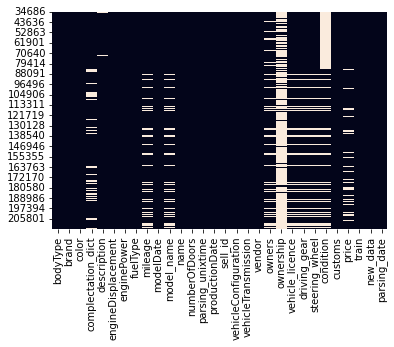

In [80]:
# missing values for the train dataset
sns.heatmap(combined_df[combined_df.train == 1].isna(), cbar=False);

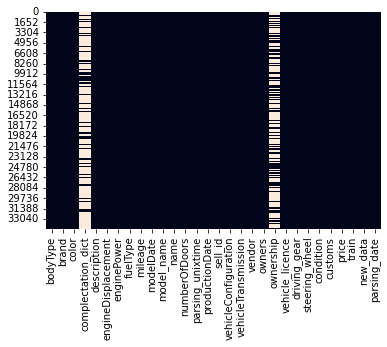

In [81]:
# missing values for the test dataset
sns.heatmap(combined_df[combined_df.train == 0].isna(), cbar=False);

## Summary:



### for both train and test datasets:
- delete 2 columns: `ownership` and `complectation_dict`;

### for train dataset:
- `price` target column: has some missing values that can only be deleted and can’t be populated;
- `model_name` and `name` columns can be merged as they seem to contain the same information;
- `vehicleConfiguration` column: duplicates information from `vehicleTransmission`, `engineDisplacement`, `bodyType`. If there are missing values in these three columns, > try to fill them in and finally delete this column;
- `mileage` column is correlated with the `modelDate` column;
- `owners` column
- all column containing information on `vehicle_licence`, `driving_gear`, `steering_wheel`, `conditions` and `customs` are missing for some number of the same observations;  

### - `price` column

In [82]:
combined_df[combined_df.train == 1].price.isna().sum(), combined_df[combined_df.train == 0].price.isna().sum()

(20598, 0)

It shows that the missing values in the `price` column present only in the train test. Let's remove them.

In [83]:
combined_df.dropna(subset=['price'], inplace=True)

In [84]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190577 entries, 0 to 214193
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   bodyType              190575 non-null  object        
 1   brand                 190577 non-null  object        
 2   color                 190577 non-null  object        
 3   complectation_dict    140687 non-null  object        
 4   description           189006 non-null  object        
 5   engineDisplacement    190484 non-null  float64       
 6   enginePower           190575 non-null  float64       
 7   fuelType              190576 non-null  object        
 8   mileage               169425 non-null  float64       
 9   modelDate             190575 non-null  float64       
 10  model_name            169425 non-null  object        
 11  name                  190576 non-null  object        
 12  numberOfDoors         190575 non-null  float64       
 13 

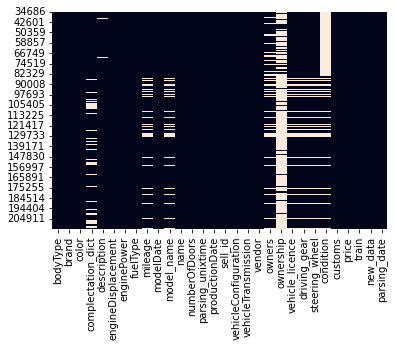

In [85]:
sns.heatmap(combined_df[combined_df.train == 1].isna(), cbar=False);

### - `condition` column

In [86]:
combined_df.condition.value_counts()

Не требует ремонта    123298
Name: condition, dtype: int64

Let's convert this variable to the binary values and all values that contained "Не требует ремонта" values will be 1 and the observations that haven't had any information 0.

In [87]:
combined_df.condition = combined_df.condition.apply(lambda x: 1 if x == 'Не требует ремонта' else 0)

### - `model_name` column

In [88]:
combined_df[combined_df.model_name.isna()].parsing_date.unique()

array(['2021-09-25T00:00:00.000000000', '2021-09-26T00:00:00.000000000',
       '2021-09-27T00:00:00.000000000', '2021-09-28T00:00:00.000000000',
       '2021-09-29T00:00:00.000000000', '2021-09-30T00:00:00.000000000',
       '2021-10-01T00:00:00.000000000'], dtype='datetime64[ns]')

All data with missing model_name column is in the newly parsed dataset. Let's try to fill the na using the information from another `name` column.

In [89]:
# save all available in the dataset model_names
available_model_names = list(combined_df.model_name.str.lower().unique())

In [90]:
combined_df.loc[combined_df.model_name.isna(), 'model_name'] = combined_df[combined_df.model_name.isna()].name.apply(
     lambda x: fill_model_name_with_name(available_model_names, x))
combined_df.model_name = combined_df.model_name.str.lower().str.replace('_', ' ')

In [91]:
combined_df.model_name.isna().sum()

0

In [92]:
cols_to_remove.append('name')

### - `vehicleConfiguration` column

duplicates information from vehicleTransmission, engineDisplacement, bodyType. If there are some missing values in these three columns > try to fill them and finally delete this column;

In [93]:
combined_df[combined_df.vehicleTransmission.isna()].vehicleConfiguration

46769     NaN
105825    NaN
Name: vehicleConfiguration, dtype: object

Let's check for autos with which fuel type we observe the missing values in the engineDisplacement column:

In [94]:
combined_df[combined_df.engineDisplacement.isna()].fuelType.value_counts()

электро      92
универсал     1
Name: fuelType, dtype: int64

As expected it is in almost all cases for electrical autos. Let's fill these values with 0.0.

In [95]:
combined_df.loc[(combined_df.engineDisplacement.isna()) & (combined_df.fuelType == 'электро'), 'engineDisplacement'] = 0.0

### - `owners` column

For the columns that have missing `owners` values and `mileage` = 0 we need to fill the `owners` column with '0' because these autos are new.

In [96]:
combined_df.loc[(combined_df.owners.isna()) & (combined_df.mileage == 0.0), 'owners'] = 0

Let's look further at the production_date of these autos, customs, mileage and so on.

In [97]:
print(combined_df[combined_df.owners.isnull()].groupby('productionDate').modelDate.count())
combined_df[combined_df.owners.isnull()].groupby('productionDate').median()

productionDate
2019.0       11
2020.0       90
2021.0    21051
Name: modelDate, dtype: int64


,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,parsing_unixtime,sell_id,owners,condition,customs,price,train,new_data
productionDate,,,,,,,,,,,,,
2019.0,3.50,283.0,NaN,2016.0,5.0,1.632792e+09,0.0,NaN,0.0,0.0,3207800.0,1.0,1.0
2020.0,2.95,330.0,NaN,2020.0,4.0,1.632799e+09,0.0,NaN,0.0,0.0,11450246.4,1.0,1.0
2021.0,2.00,190.0,NaN,2018.0,5.0,1.632780e+09,0.0,NaN,0.0,0.0,3526000.0,1.0,1.0


It looks like we have absolutely new autos here, therefore we have 0 in customs and missing owners and mileage values. Let's fill them in with 0.

In [98]:
combined_df.loc[combined_df.owners.isnull(), ['mileage', 'owners']] = 0

In [99]:
combined_df.vehicle_licence.value_counts()

original     149191
duplicate     19976
Name: vehicle_licence, dtype: int64

In [100]:
combined_df[combined_df.vehicle_licence.isnull()].groupby('productionDate')[['mileage', 'owners']].median()

,mileage,owners
productionDate,,
1999.0,276000.0,3.0
2018.0,0.0,0.0
2019.0,0.0,0.0
2020.0,0.0,0.0
2021.0,0.0,0.0


Let's fill these values with 'original' for new autos. And 'duplicate' for the autos with any # owners.

In [101]:
combined_df.loc[(combined_df.vehicle_licence.isna()) & (combined_df.mileage == 0.0), 'vehicle_licence'] = 'original'
combined_df.loc[(combined_df.vehicle_licence.isna()) & (combined_df.mileage != 0.0), 'vehicle_licence'] = 'duplicate'

### - `driving_gear` and `steering_wheel` columns

can be filled with the most popular value between the same brand 

In [102]:
combined_df.steering_wheel.value_counts()

left     163438
right      5986
Name: steering_wheel, dtype: int64

In [103]:
right_wheel_models = combined_df[combined_df.steering_wheel == 'right'].groupby(['brand', 'model_name']).bodyType.count() 
right_wheel_models = right_wheel_models.reset_index().sort_values('bodyType', ascending=False)
right_wheel_dict = right_wheel_models[right_wheel_models.bodyType > 1].groupby('brand').agg({'model_name': lambda x: x.tolist()}).to_dict()['model_name']

In [104]:
combined_df.loc[combined_df.steering_wheel.isna(), 'steering_wheel'] = combined_df[combined_df.steering_wheel.isna()].apply(
    lambda row: fill_steering_wheel(row.brand, row.model_name, right_wheel_dict), axis=1)

In [105]:
driving_gear_df = combined_df.groupby(['brand', 'model_name', 'driving_gear']).bodyType.count().reset_index().drop_duplicates(['brand', 'model_name']).drop(columns=['bodyType'])

In [106]:
combined_df.loc[combined_df.driving_gear.isna(), 'driving_gear'] = combined_df[combined_df.driving_gear.isna()].apply(
    lambda row: fill_driving_gear(row.brand, row.model_name, driving_gear_df), axis=1)

In [107]:
cols_to_remove.append('complectation_dict')

### - `numberOfDoors` column

In [108]:
combined_df.numberOfDoors.value_counts()

5.0    119184
4.0     63396
2.0      5494
3.0      2499
0.0         2
Name: numberOfDoors, dtype: int64

In [109]:
combined_df[combined_df.numberOfDoors == 0]

,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,...,ownership,vehicle_licence,driving_gear,steering_wheel,condition,customs,price,train,new_data,parsing_date
16944,кабриолет,MERCEDES,белый,NaN,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3,32.0,бензин,48000.0,1904.0,...,6 лет и 8 месяцев,original,задний,right,1,1,0.0,0,0,2020-10-21
83399,кабриолет,MERCEDES,белый,{'id': '0'},"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3,32.0,бензин,48000.0,1904.0,...,"{'year': 2014, 'month': 2}",original,задний,right,0,1,12000000.0,1,0,2020-09-08


They are old autos and could be that they didn't have doors. One observation is in test dataset and another one is in train. Let's leave them.

Remove all left missing values in the train set.

In [110]:
combined_df[combined_df.train == 1].dropna(inplace=True)

In [111]:
combined_df.isna().sum(axis=0)

bodyType                     2
brand                        0
color                        0
complectation_dict       49890
description               1571
engineDisplacement           1
enginePower                  2
fuelType                     1
mileage                      0
modelDate                    2
model_name                   0
name                         1
numberOfDoors                2
parsing_unixtime             0
productionDate               0
sell_id                      0
vehicleConfiguration         2
vehicleTransmission          2
vendor                       0
owners                       0
ownership               151713
vehicle_licence              0
driving_gear                 0
steering_wheel               0
condition                    0
customs                      0
price                        0
train                        0
new_data                     0
parsing_date                 0
dtype: int64

In [112]:
# for col in ['enginePower', 'numberOfDoors', 'productionDate', 'owners', 'modelDate']:
#     combined_df[col] = combined_df[col].astype(int)

# 3.5. Detailed EDA of all features, outliers' detection

Let's look at the number of unique values per each column and on their data types that can help us to split the columns into categories.

In [113]:
combined_df.nunique(dropna=False)

bodyType                    19
brand                       12
color                       16
complectation_dict        7555
description              95977
engineDisplacement          56
enginePower                340
fuelType                     7
mileage                  28726
modelDate                   72
model_name                 708
name                      5380
numberOfDoors                6
parsing_unixtime        144452
productionDate              73
sell_id                  34687
vehicleConfiguration      1622
vehicleTransmission          3
vendor                       2
owners                       4
ownership                  576
vehicle_licence              2
driving_gear                 3
steering_wheel               2
condition                    2
customs                      2
price                    14457
train                        2
new_data                     2
parsing_date                14
dtype: int64

In [114]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190577 entries, 0 to 214193
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   bodyType              190575 non-null  object        
 1   brand                 190577 non-null  object        
 2   color                 190577 non-null  object        
 3   complectation_dict    140687 non-null  object        
 4   description           189006 non-null  object        
 5   engineDisplacement    190576 non-null  float64       
 6   enginePower           190575 non-null  float64       
 7   fuelType              190576 non-null  object        
 8   mileage               190577 non-null  float64       
 9   modelDate             190575 non-null  float64       
 10  model_name            190577 non-null  object        
 11  name                  190576 non-null  object        
 12  numberOfDoors         190575 non-null  float64       
 13 

## Split the columns into groups based on their types

In [115]:
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'model_name', 'name', 'driving_gear', 'owners', 'numberOfDoors']
num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'modelDate', 'productionDate']
bin_cols = ['condition', 'customs', 'steering_wheel', 'vehicleTransmission', 'vendor', 'vehicle_licence']
help_cols = ['train', 'sell_id', 'parsing_date']
target_cols = ['price']

all_cols = cat_cols + num_cols + bin_cols + help_cols + target_cols
len(all_cols)

24

# - Analysis of numerical columns: distribution, correlation, outliers

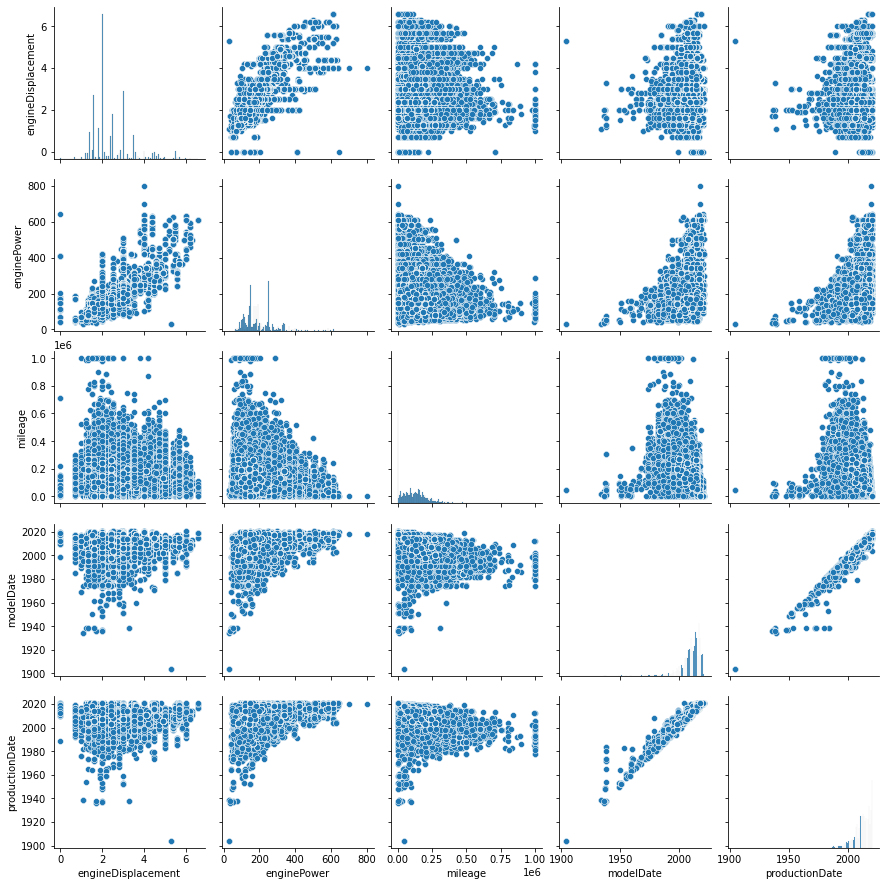

In [116]:
sns.pairplot(combined_df[num_cols]);

Looking at the distribution we can see that `modelDate` and `productionDate` columns are highly correlated. We need to remove one of these columns in the end. In all cases we don't see a normal distribution for the values, and the distributions are either right- or left-skewed.

In [117]:
combined_df[num_cols].describe()

,engineDisplacement,enginePower,mileage,modelDate,productionDate
count,190576.000000,190575.000000,190577.000000,190575.000000,190577.000000
mean,2.433729,200.856450,117656.521144,2010.684240,2012.872141
std,0.941924,94.577759,101042.005619,7.280411,7.091049
min,0.000000,30.000000,0.000000,1904.000000,1904.000000
25%,1.800000,144.000000,33000.000000,2007.000000,2009.000000
50%,2.000000,180.000000,105000.000000,2012.000000,2014.000000
75%,3.000000,249.000000,175000.000000,2016.000000,2018.000000
max,6.600000,800.000000,1000000.000000,2021.000000,2021.000000


We can see that the range of the values of numerical columns is too different, we need to **normalize** them before the ML step. As well the observations about heavy right or left tails are confirmed with the statistics data, therefore it makes sense to try to use the log values. For this we need to check how the distribution of the log valued numerical columns will look like as well as to check the outliers.

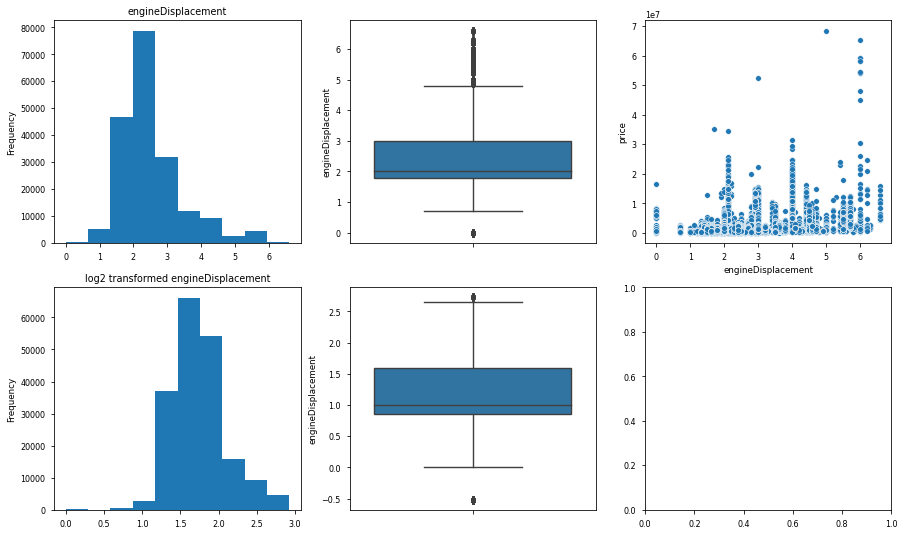

None

,left,right
borders,0.713567,2.77186
# outliers,249.000000,292.00000



----------



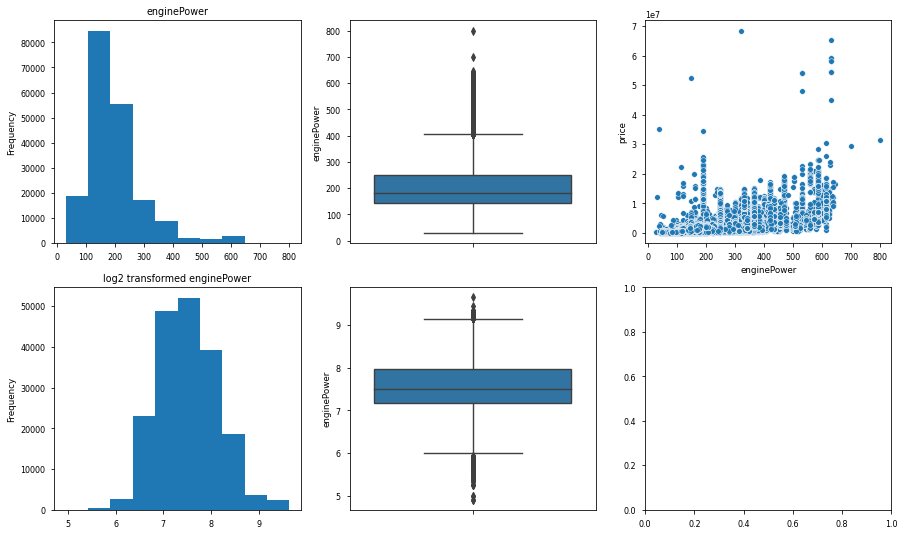

None

,left,right
borders,6.001096,9.144597
# outliers,525.000000,2836.000000



----------



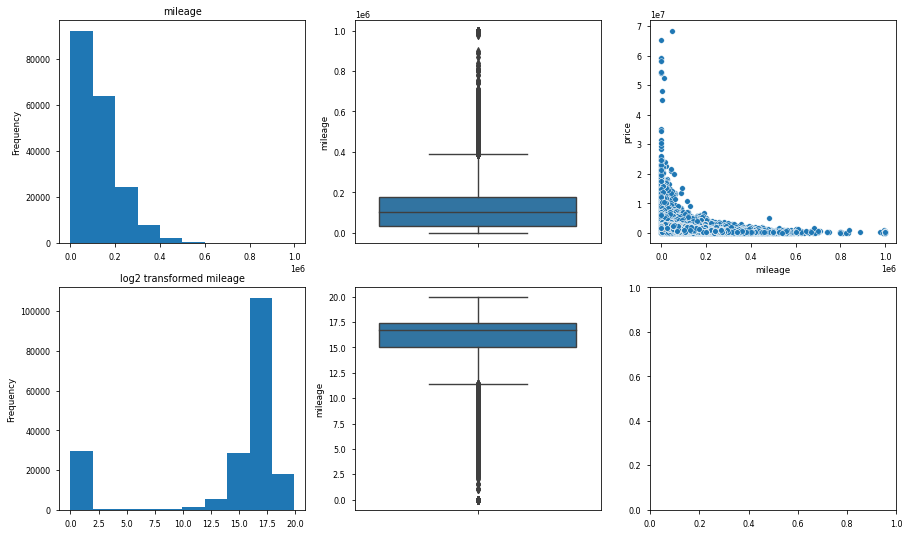

None

,left,right
borders,11.40005,21.027176
# outliers,31742.00000,0.000000



----------



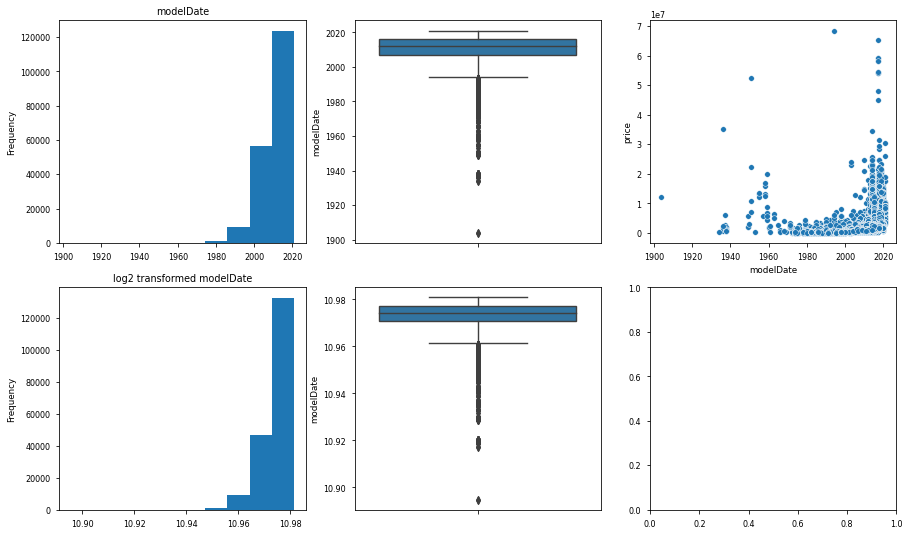

None

,left,right
borders,10.961866,10.987673
# outliers,5436.000000,0.000000



----------



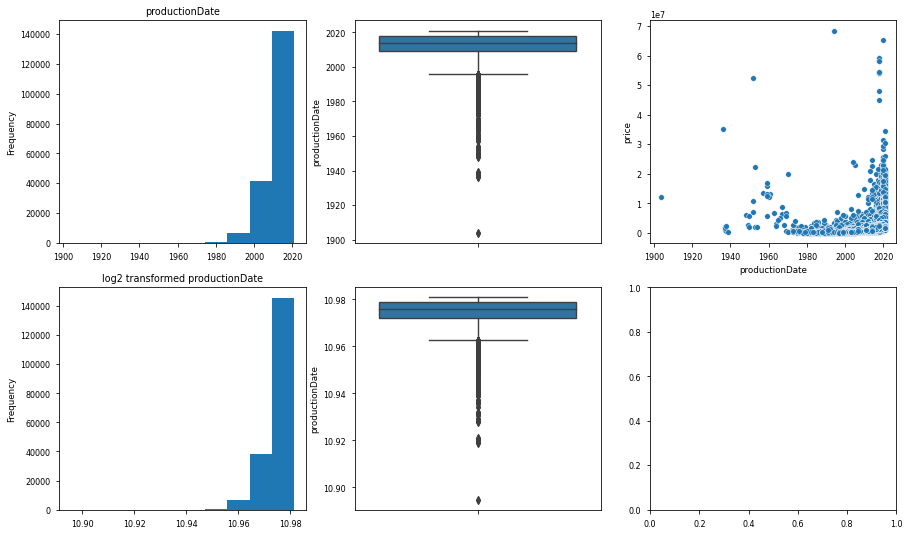

None

,left,right
borders,10.963312,10.989093
# outliers,4938.000000,0.000000



----------



In [118]:
for each in num_cols:
    display(vis_num_feature(combined_df, each, 'price', 'train == 1'))
    display(calculate_stat_outliers(combined_df, each, log=True))
    print('\n' + '-' * 10 + '\n')

Log transformation helps in the case of `enginePower` feature, let's do it later. We see a lot of outliers for our numerical features. To make a final decision what to do with them, it would be good to analyze them in more details.

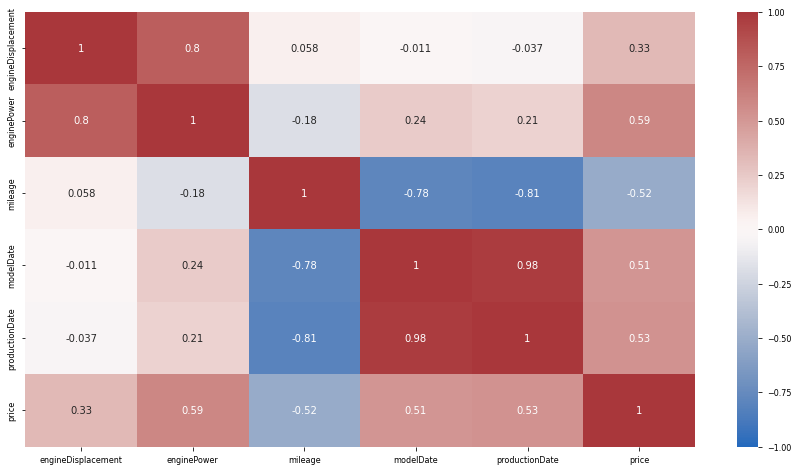

In [119]:
plt.figure(figsize=(15, 8));
sns.heatmap(combined_df[combined_df.train == 1][num_cols + ['price']].corr(), vmin=-1, vmax=1, annot=True, cmap='vlag');

Here we may observe strongly correlated features:
- `modelDate` and `productionDate` (Pearson correlation coefficient = 0.98, direct correlation) > looking at the correlation with the target variable it is worth keeping the `productionDate` (higher coefficient) and removing the `modelDate` feature;
- `enginePower` and `engineDisplacement` (Pearson correlation coefficient = 0.80, direct correlation) > these two features also demostrate high correlation. Similar to the previous decision, let's leave the feature that has higher correlation with the target variable: `enginePower` and remove the `engineDisplacement` feature.
- `productionDate` and `mileage` (Pearson correlation coefficient = -0.81, indirect correlation) > these two features also show a high indirect correlation. Both features are high correlated with the target variable, let's analyze them both in more details and decide whether to remove the `mileage` feature from the dataset.

In [120]:
cols_to_remove.extend(['modelDate', 'engineDisplacement'])

### More detailed analysis of numerical features:

### - `enginePower`

Let's look at the distribution of the enginePower in the train and test datasets separately.

In [121]:
combined_df.query('train == 1').enginePower.describe(), combined_df.query('train == 0').enginePower.describe()

(count    155889.000000
 mean        203.673871
 std          95.528933
 min          30.000000
 25%         144.000000
 50%         180.000000
 75%         249.000000
 max         800.000000
 Name: enginePower, dtype: float64,
 count    34686.000000
 mean       188.194142
 std         89.087035
 min         30.000000
 25%        125.000000
 50%        169.000000
 75%        233.000000
 max        639.000000
 Name: enginePower, dtype: float64)

It's shown that the min value is similar for the train and test datasets. Let's leave it like this then. But the max value is much higher in the train dataset. Let's look at these observations which enginePower value is higher in comparison to the test dataset.

In [122]:
combined_df[(combined_df.train == 1) & (combined_df.enginePower > combined_df.query('train == 0').enginePower.max())]

,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,...,ownership,vehicle_licence,driving_gear,steering_wheel,condition,customs,price,train,new_data,parsing_date
79243,внедорожник,MERCEDES,чёрный,"{'id': '21715492', 'name': 'Individual', 'avai...",BRABUS G700 WIDESTAR на базе G63\n700 л.с.\n\n...,4.0,700.0,бензин,0.0,2018.0,...,NaN,original,полный,left,0,1,29300000.0,1,0,2020-09-08
79310,внедорожник,MERCEDES,чёрный,"{'id': '21715492', 'name': 'Individual', 'avai...",BRABUS G800 WIDESTAR на базе G63\n800 л.с.\n\n...,4.0,800.0,бензин,0.0,2018.0,...,NaN,original,полный,left,0,1,31600000.0,1,0,2020-09-08
94703,седан,AUDI,серый,NaN,Первый в России RS E tron GT EDITION ONE на ро...,0.0,646.0,электро,250.0,2020.0,...,5 месяцев,original,полный,left,1,1,16387300.0,1,1,2021-09-26


There are only 3 observations here. They could be outliers therefore we could allow us to delete them.

In [123]:
combined_df.drop(
    combined_df[(combined_df.train == 1) & (combined_df.enginePower > combined_df.query('train == 0').enginePower.max())].index, inplace=True
)

### - `mileage`

In [124]:
combined_df.query('train == 1').mileage.describe(), combined_df.query('train == 0').mileage.describe()

(count     155888.000000
 mean      107789.924632
 std        98441.941761
 min            0.000000
 25%        21000.000000
 50%        95000.000000
 75%       162876.000000
 max      1000000.000000
 Name: mileage, dtype: float64,
 count      34686.000000
 mean      162009.767889
 std       100676.559489
 min            1.000000
 25%        91153.500000
 50%       149779.500000
 75%       215000.000000
 max      1000000.000000
 Name: mileage, dtype: float64)

We can see that the highest mileage value presents in both train and test datasets. Therefore, we'll leave the data how they are without changes.
Previously, we observed that in the mileage distribution we observed a separate column in the hist with 0 values. Let's try to look at the distribution of mileage for different productionDates or modelDates:

(0.0, 4000.0)

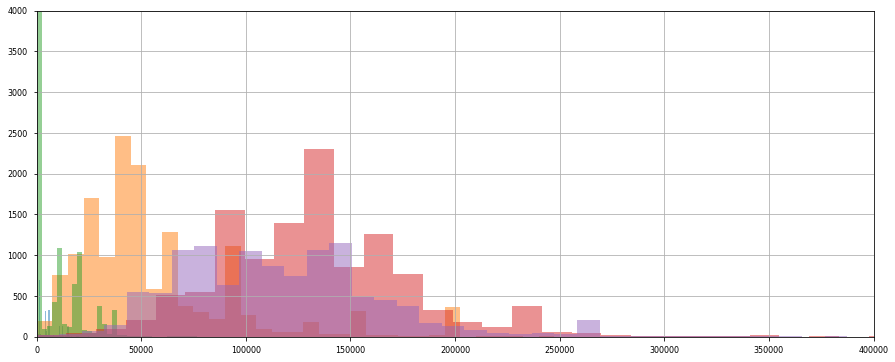

In [125]:
plt.figure(figsize=(15, 6))
for year in combined_df.productionDate.value_counts().index[:5]:
    combined_df[combined_df.productionDate == year].mileage.hist(bins=50, alpha=0.5)
plt.xlim(0, 400000)
plt.ylim(0, 4000)

In this case we see that the distribution is more normal. Therefore, it makes sense to create a more informative feature such as how many km per year an auto drove.

<AxesSubplot:xlabel='mileage', ylabel='price'>

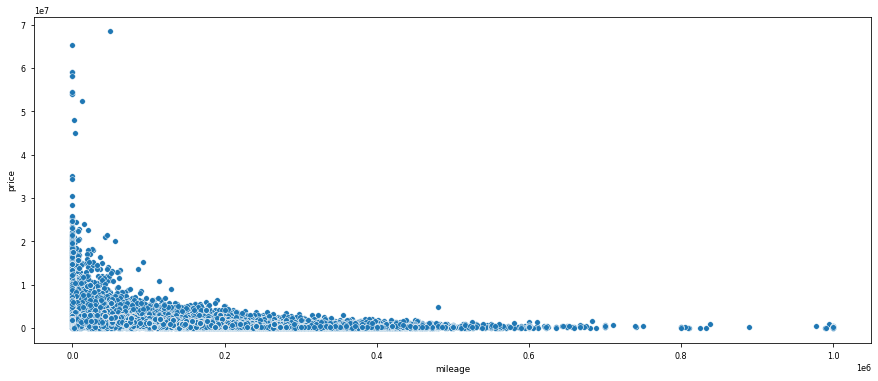

In [126]:
plt.figure(figsize=(15, 6))
sns.scatterplot(data=combined_df[combined_df['train'] == 1], x='mileage', y="price")

We can observe a big descrease in price with the increase of the mileage. Maybe to use it to generate a new feature later.

### - `productionDate`

In [127]:
combined_df.query('train == 1').productionDate.describe(), combined_df.query('train == 0').productionDate.describe()

(count    155888.000000
 mean       2013.674696
 std           6.846882
 min        1904.000000
 25%        2011.000000
 50%        2015.000000
 75%        2019.000000
 max        2021.000000
 Name: productionDate, dtype: float64,
 count    34686.000000
 mean      2009.264602
 std          7.047661
 min       1904.000000
 25%       2006.000000
 50%       2011.000000
 75%       2014.000000
 max       2020.000000
 Name: productionDate, dtype: float64)

The statistics is similar for this feature in the train and test datasets. We have some old autos. Let's look how many.

In [128]:
combined_df[combined_df.productionDate < 1960]

,bodyType,brand,color,complectation_dict,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,...,ownership,vehicle_licence,driving_gear,steering_wheel,condition,customs,price,train,new_data,parsing_date
1777,хэтчбек,SKODA,чёрный,NaN,"Авто после длительного простоя, под восстановл...",1.1,30.0,бензин,14000.0,1934.0,...,NaN,original,задний,left,1,1,0.00,0,0,2020-10-20
3174,седан,AUDI,чёрный,NaN,"Ауди кабриолет, 1938 г., ретро, на ходу, есть ...",3.3,75.0,бензин,90000.0,1938.0,...,34 года и 2 месяца,original,задний,left,1,1,0.00,0,0,2020-10-19
9143,седан,BMW,чёрный,NaN,"Для тех, кто разбирается!! Настоящий бмв. Авто...",2.0,51.0,бензин,44100.0,1949.0,...,NaN,original,задний,left,1,1,0.00,0,0,2020-10-19
9373,седан,BMW,чёрный,NaN,"Машина в рабочем состояние,доедет куда угодно,...",2.0,51.0,бензин,88000.0,1949.0,...,NaN,original,задний,left,1,1,0.00,0,0,2020-10-19
9495,седан,BMW,чёрный,NaN,Ретро автомобиль. Кузов в оригинале. Салон кож...,2.0,46.0,бензин,25000.0,1937.0,...,NaN,original,задний,left,1,1,0.00,0,0,2020-10-19
9625,седан,BMW,бежевый,NaN,Оригинальные запчасти. Своевременное обслужива...,2.0,51.0,бензин,16000.0,1936.0,...,NaN,original,задний,left,1,1,0.00,0,0,2020-10-19
9819,седан,BMW,чёрный,NaN,"БМВ 321 1937 г., прекрасно восстановленная, вы...",2.0,46.0,бензин,4500.0,1937.0,...,NaN,original,задний,left,1,1,0.00,0,0,2020-10-19
15808,кабриолет,MERCEDES,серебристый,NaN,Продается ретро автомобиль Мерседес Бенц 220S ...,2.2,120.0,бензин,58726.0,1958.0,...,14 лет и 3 месяца,original,задний,left,1,1,0.00,0,0,2020-10-21
16891,седан,MERCEDES,красный,NaN,"Очень редкое авто, было произведено менее 100 ...",1.7,38.0,бензин,1.0,1936.0,...,NaN,original,задний,left,1,1,0.00,0,0,2020-10-21
16944,кабриолет,MERCEDES,белый,NaN,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",5.3,32.0,бензин,48000.0,1904.0,...,6 лет и 8 месяцев,original,задний,right,1,1,0.00,0,0,2020-10-21


We have 41 rare autos in the dataset. We can add a separate column later: whether the auto old is or not.

<AxesSubplot:xlabel='productionDate', ylabel='price'>

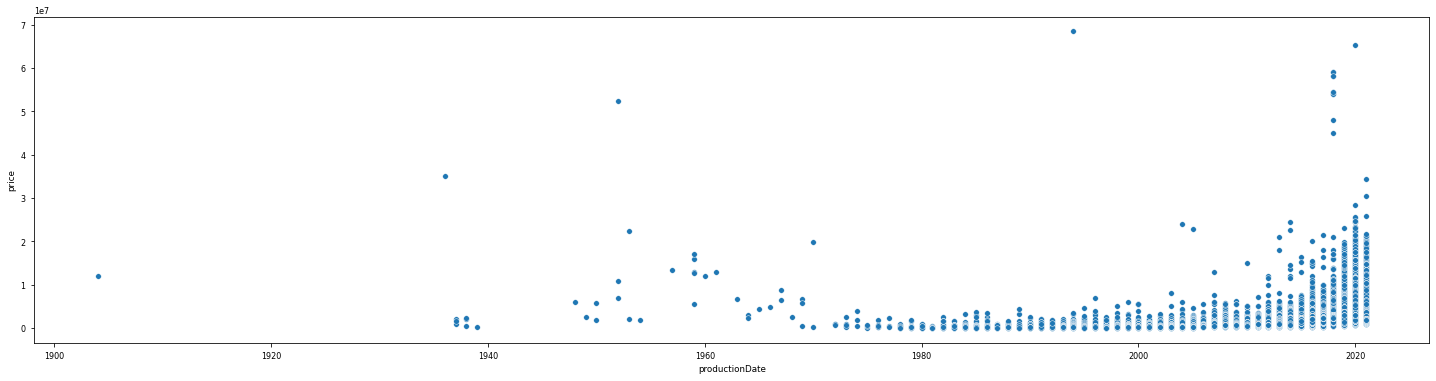

In [129]:
plt.figure(figsize=(25, 6))
sns.scatterplot(data=combined_df[combined_df['train'] == 1], x='productionDate', y="price")

There are quite significant drops in the price after 3 years and 5 years. Let's create new binary columns for these observations later.

In [130]:
# combined_df.drop(labels=['modelDate', 'engineDisplacement'], axis=1, inplace=True)

In [131]:
for col in ['modelDate', 'engineDisplacement']:
    num_cols.remove(col)

# - Analysis of binary and categorical columns

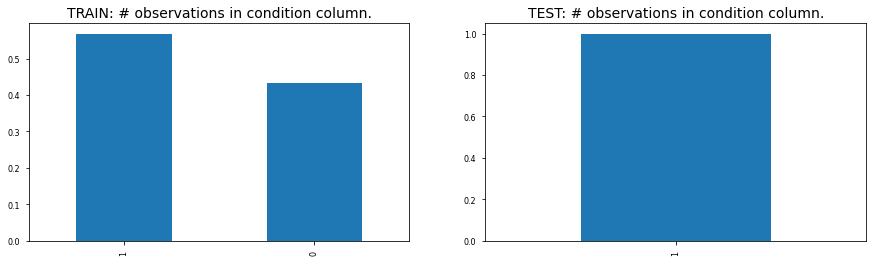

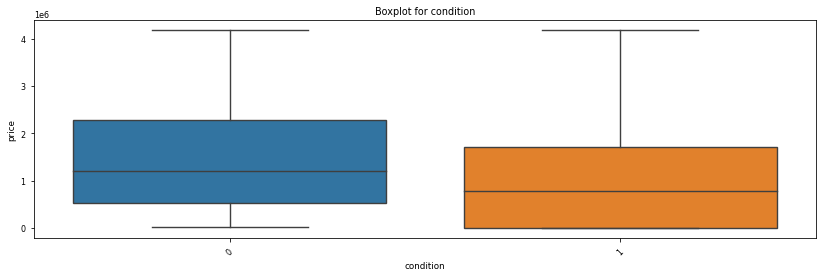

______________________________________________________________________________________________________________________________________________________




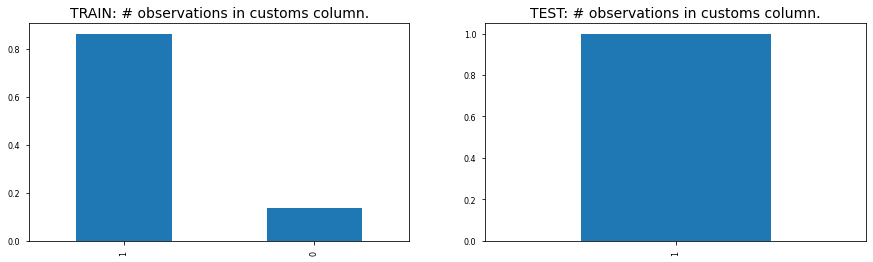

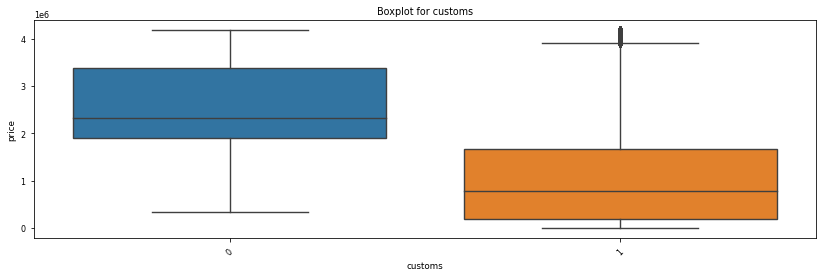

______________________________________________________________________________________________________________________________________________________




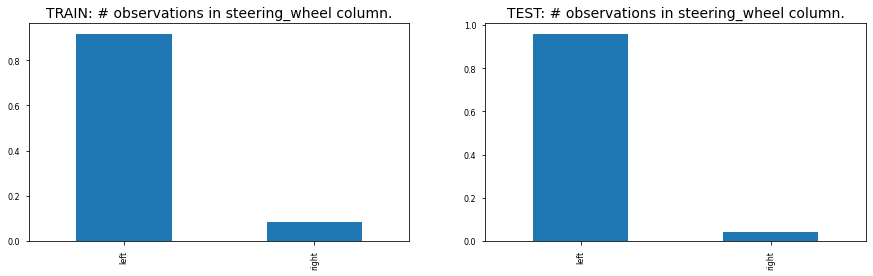

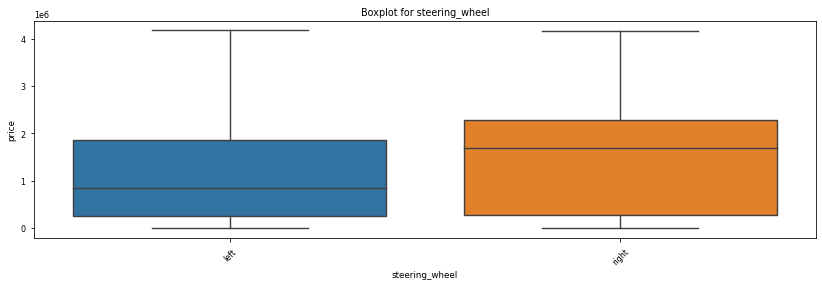

______________________________________________________________________________________________________________________________________________________




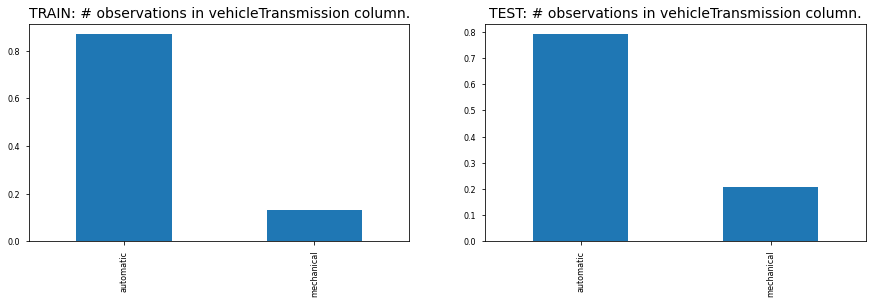

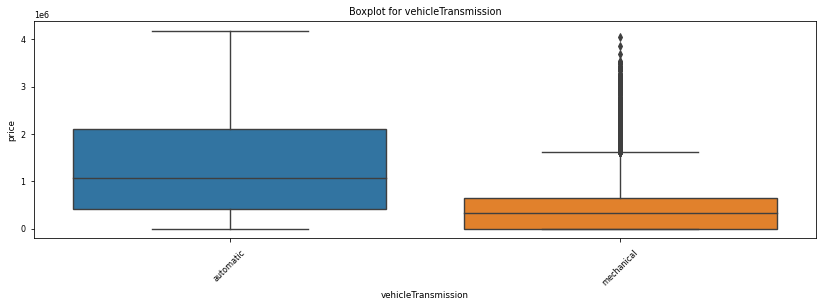

______________________________________________________________________________________________________________________________________________________




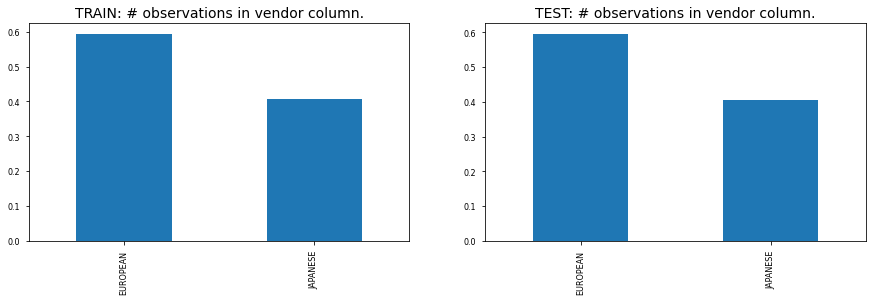

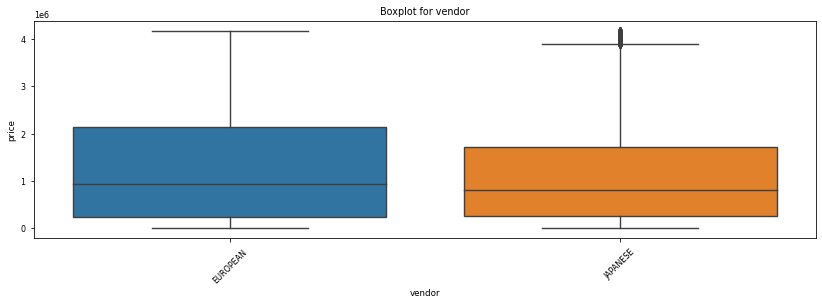

______________________________________________________________________________________________________________________________________________________




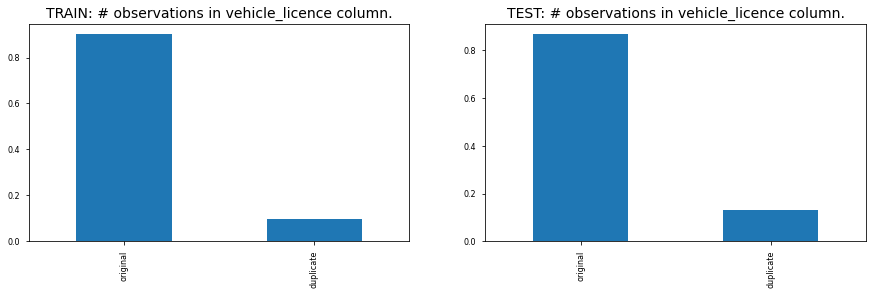

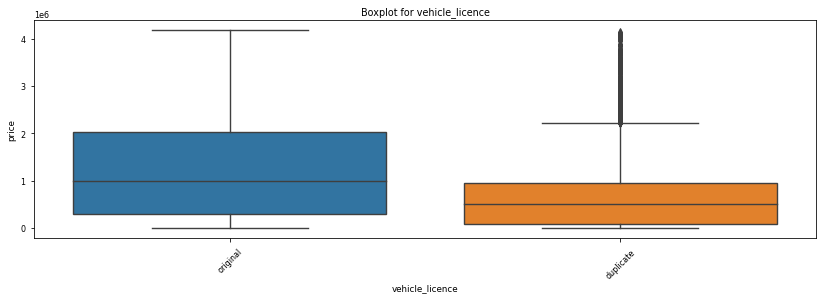

______________________________________________________________________________________________________________________________________________________




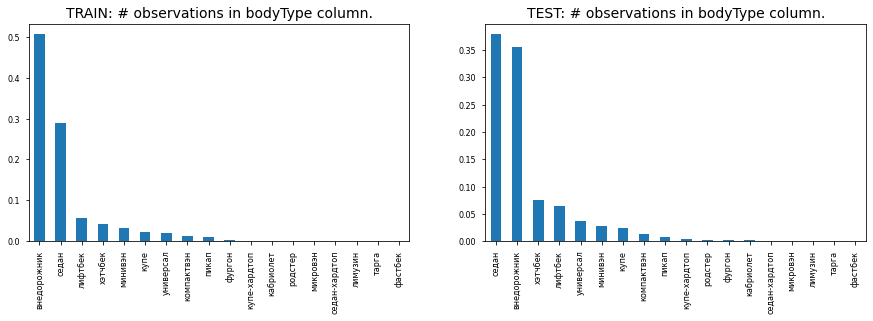

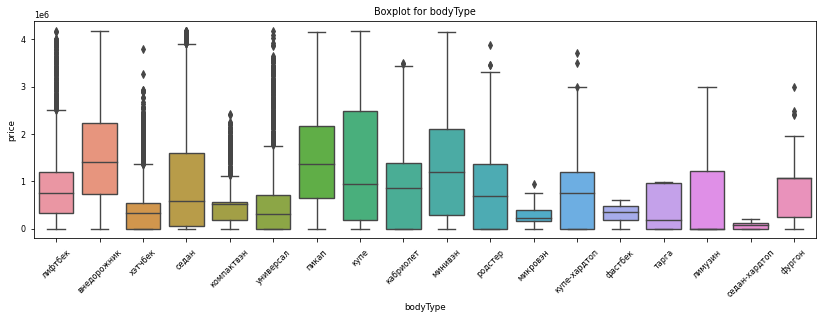

______________________________________________________________________________________________________________________________________________________




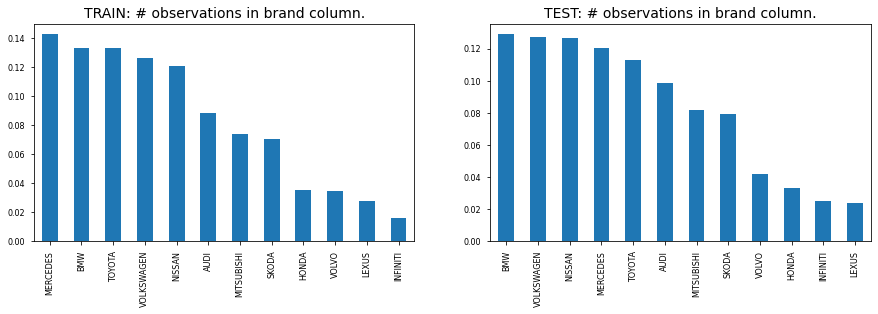

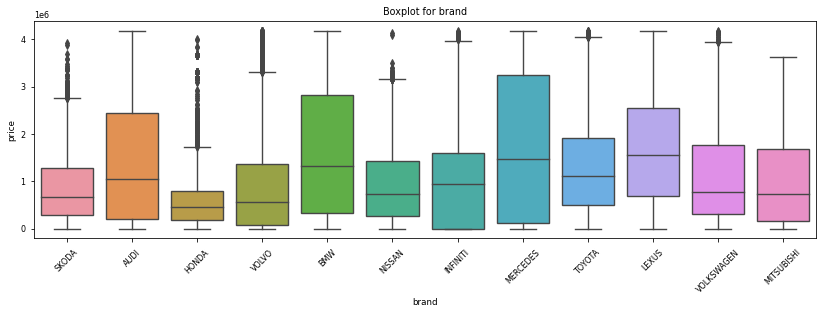

______________________________________________________________________________________________________________________________________________________




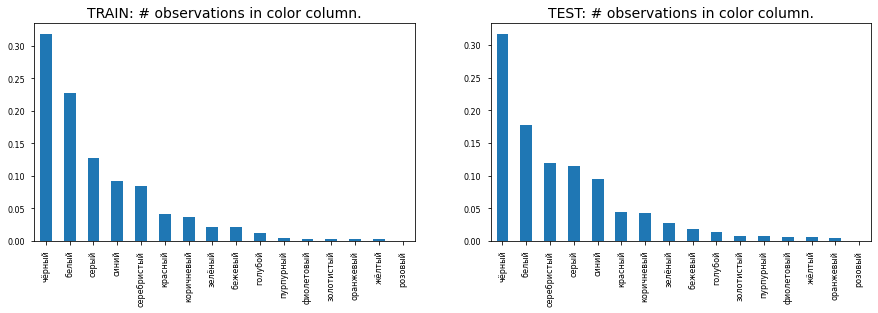

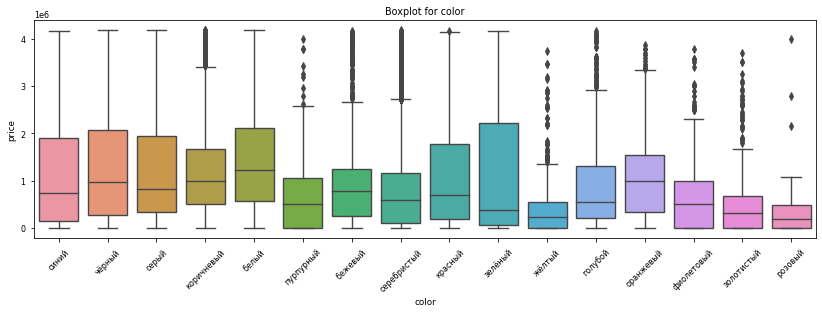

______________________________________________________________________________________________________________________________________________________




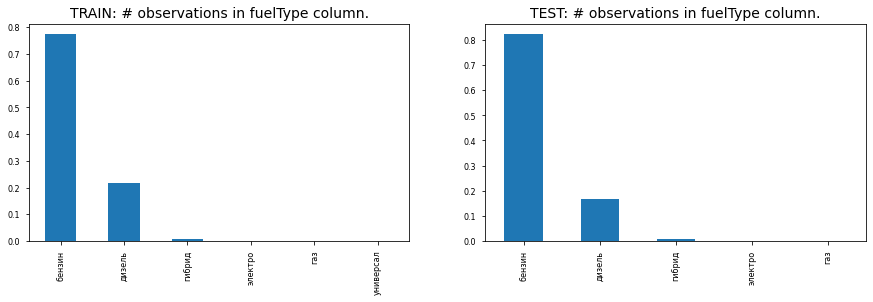

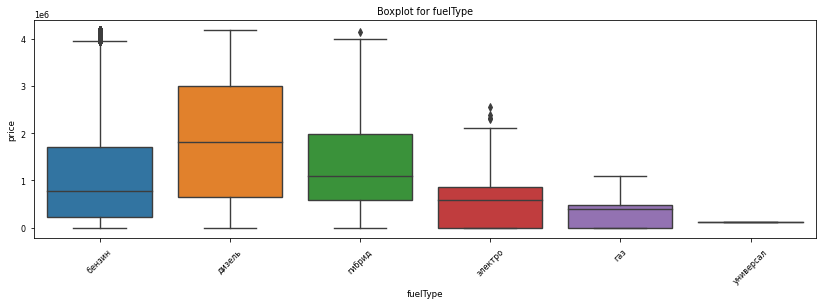

______________________________________________________________________________________________________________________________________________________




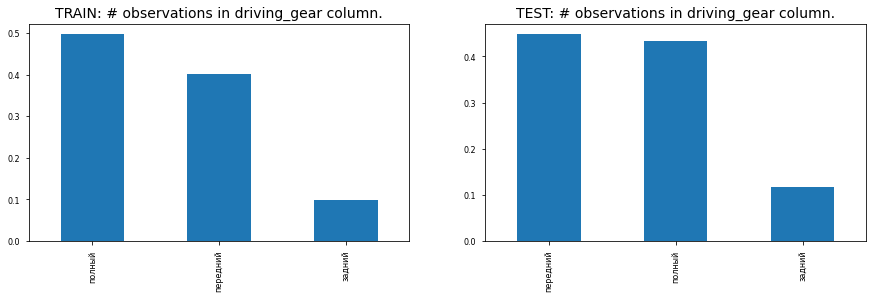

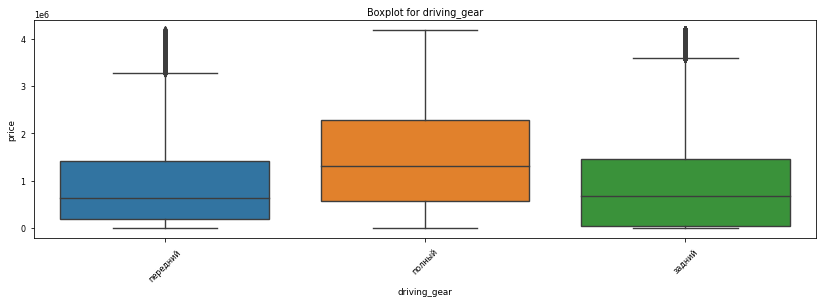

______________________________________________________________________________________________________________________________________________________




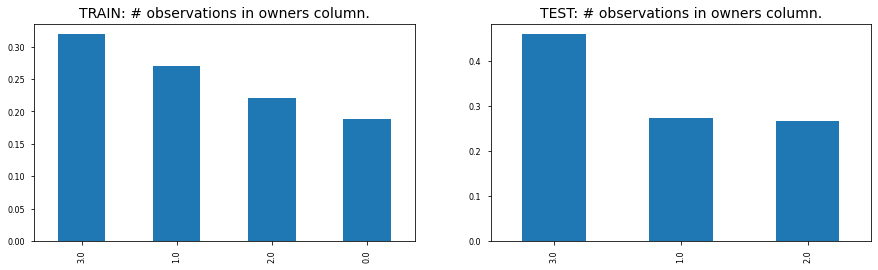

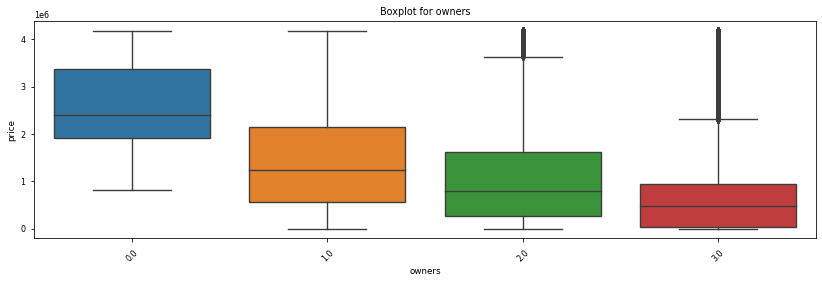

______________________________________________________________________________________________________________________________________________________




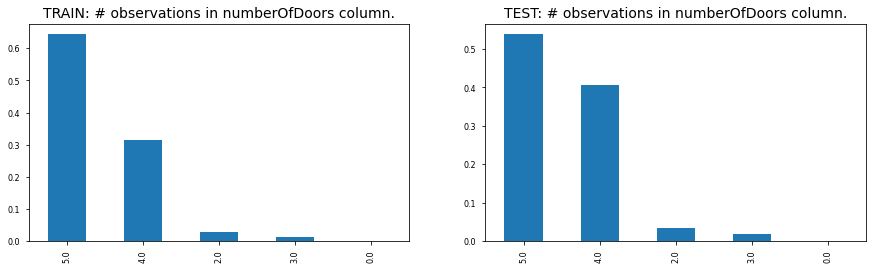

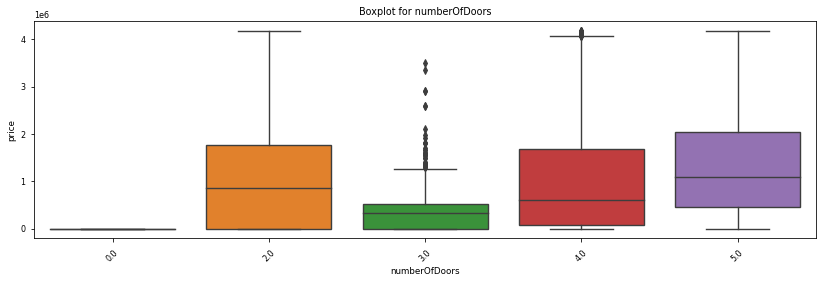

______________________________________________________________________________________________________________________________________________________




In [132]:
for col in bin_cols + cat_cols:
    if col not in ['model_name', 'name']: # these columns have too many categories, the plots don't show any useful information for them. Create new features!
        fig, ax = plt.subplots(figsize=(15, 4), ncols=2, nrows=1)
        ax[0].set_title(f'TRAIN: # observations in {col} column.', fontdict={'fontsize': 14})
        combined_df[combined_df.train == 1][col].value_counts(normalize=True).plot(kind='bar', ax=ax[0])
        ax[1].set_title(f'TEST: # observations in {col} column.', fontdict={'fontsize': 14})
        combined_df[combined_df.train == 0][col].value_counts(normalize=True).plot(kind='bar', ax=ax[1])
        # to visualize the boxplots for the price that has a lot of outliers we'll use 90% quantile for the price
        show_boxplot(data=combined_df[combined_df.price <= combined_df.price.quantile(0.9)], column=col, target_column='price')
        print('_' * 150)
        print('\n')
        plt.show()

## SUMMARY (there are no balanced features):

-  `condition` and `customs` columns: comparing the relative frequencies of unique values in the training and test datasets, only one value for each of the above columns is present in the test set.  This means that it makes sense to remove these two columns from the analysis. TODO: check later!

## Heavy unbalanced features:
- `steeting_wheel` column: the relative frequencies of unique values for this feature are similar in the train and test sets. “Left” occurs about 90-95% of the time;
- `vehicleTransmission` column: the relative frequencies of the unique values for this feature are similar in train and test sets. "Automatic" is found in about 80-85% of cases. Prices for automatic cars are also higher than for mechanical cars;
- `vehicle_licence` column: here we observe unbalanced distribution, with ~85-90% "original" and ~10-15% "duplicate" values in both datasets. The distribution of prices for vehicles with an 'original' vehicle licence is higher;
- `bodyType` column: in the train and test datasets,the two most common values are ‘внедорожник’ and ‘седан’ (~30-50% for each). But if we look at the price distribution between different body types we see for each type quite significant differences for each type. Based on this information, we can create a new binary feature `top2_bodyType`;
- `brand` column: here we can see the distribution of the 12 brands represented in the dataset and it looks similar for train and test datasets. The prices vary significantly but there are some trends: the iqr for ‘Mercedes’ is the largest > ‘bmv’ > ‘audi’ etc.;
- `color` column: the distribution of this feature is similar for the train and test datasets, but we can create `top5 colours`: черный, белый, серый, синий, серебристый - based on their frequencies and similar price distribution > let’s create a new binary column;
- `fuelType` column: similar distributions for the train and test sets. The most popular is ‘бензин’ (~80%) but ‘дизель’ has higher prices;
- `numberOfDoors` column: cars with 4-5 doors dominate in both train and test datasets. Let's create a `top2_door_num`. The cheapest autos with 3 doors;
- `model` and `model_name` columns: we haven’t shown them in the graphs because there are too many categories.

## Relatively balanced features:
- `vendor` column: here we see ~60% ‘european’ and ~40% ‘japanese’ autos in both datasets. The price distribution is also similar for both vendors;
- `driving_gear` column: almost the same distribution of ‘передне-‘ and ‘полноприводых’ in the train and test datasets. But prices are much higher for the ‘полноприводых’ autos;
- `owners` column: there are no observations in test dataset without owners (no new autos?). There is a linear correlation between the number of owners and price. For cars with 0 owners it's worth to create a new binary column: `new`.

In [133]:
cols_to_remove.extend(['condition', 'customs'])

# - Target feature ('price') analysis

Let's look at the distribution of the `price` column.

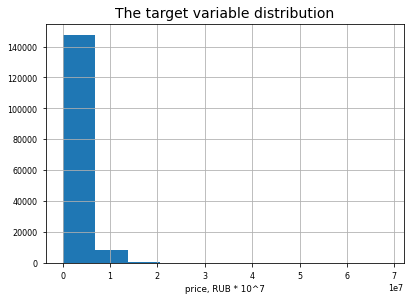

In [134]:
combined_df.query('train == 1').price.hist();
plt.title('The target variable distribution', fontdict={'fontsize': 14});
plt.xlabel('price, RUB * 10^7');

The distribution has heavy right tail, therefore it makes sense to try to log-transform it.

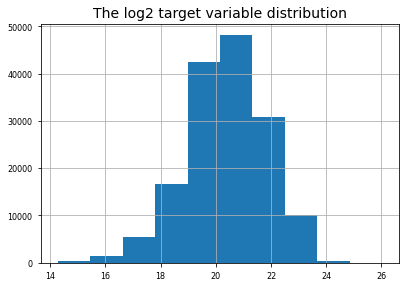

In [135]:
np.log2(combined_df.query('train == 1').price).hist();
plt.title('The log2 target variable distribution', fontdict={'fontsize': 14});

Now it looks like the normal distribution. Let's add this column to the dataset:

In [136]:
combined_df['price_log2'] = np.log2(combined_df.price + 1)
# combined_df['price_log2'].replace([np.inf, -np.inf], 0, inplace=True)

We can also try to convert the 'RUB' into "EURO" based on the conversion course on the parsing_date (because we don't know when the ads were added to the website).

In [137]:
combined_df.parsing_date.unique()

array(['2020-10-20T00:00:00.000000000', '2020-10-19T00:00:00.000000000',
       '2020-10-21T00:00:00.000000000', '2020-10-24T00:00:00.000000000',
       '2020-10-25T00:00:00.000000000', '2020-10-26T00:00:00.000000000',
       '2020-09-08T00:00:00.000000000', '2021-09-25T00:00:00.000000000',
       '2021-09-26T00:00:00.000000000', '2021-09-27T00:00:00.000000000',
       '2021-09-28T00:00:00.000000000', '2021-09-29T00:00:00.000000000',
       '2021-09-30T00:00:00.000000000', '2021-10-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [138]:
combined_df.parsing_date = combined_df.parsing_date.dt.strftime("%Y-%m-%d")
combined_df.parsing_date.unique()

array(['2020-10-20', '2020-10-19', '2020-10-21', '2020-10-24',
       '2020-10-25', '2020-10-26', '2020-09-08', '2021-09-25',
       '2021-09-26', '2021-09-27', '2021-09-28', '2021-09-29',
       '2021-09-30', '2021-10-01'], dtype=object)

In [139]:
c = CurrencyConverter(fallback_on_missing_rate=True)

converter_dict = {}
for each in combined_df.parsing_date.unique():
    # no data from September 2021
    year, month, day = [int(value) for value in each.split('-')]
    try:
        converter_dict[each] = c.convert(1, 'RUB', 'EUR', date=datetime(year, month, day))
    except:
        print(each)
        
converter_dict['2021-09-25'] = 0.01172
converter_dict['2021-09-26'] = 0.01174
converter_dict['2021-09-27'] = 0.01177
converter_dict['2021-09-28'] = 0.01180
converter_dict['2021-09-29'] = 0.01181
converter_dict['2021-09-30'] = 0.01186
converter_dict['2021-10-01'] = 0.01180

2021-09-25
2021-09-26
2021-09-27
2021-09-28
2021-09-29
2021-09-30
2021-10-01


In [140]:
combined_df['price_EURO'] = combined_df.apply(lambda x: x.price * converter_dict[x.parsing_date] if x.price != 0 else x.price, axis=1)

# 3.6. Feature engineering

### numerical columns
- `mileage_per_year`: using the `productionDate` and `mileage` columns to extract the information how many km the auto drove per year;
- `age_years`: how old is the auto in years;
- `time_bw_model_product`: the difference in years between the release of the model and her production;
- `descr_words_count`: the count of words in the description of the auto;

### binary columns
- `rarity`: whether the auto was produced before 1940;
- `older_3y`: whether the auto is older than 3 years;
- `older_5y`: whether the auto is older than 5 years;
- `sport`: weather the auto is a sport car; #was removed from the analysis
- `dealer`: whether the auto dealer published an ad; #was removed from the analysis
- `top2_bodyType`: whether the auto has ‘внедорожник’ and ‘седан’ body type;
- `rate_bodyType` : whether the auto has the rare body type: 'микровэн', 'седан-хардтоп', 'лимузин', 'тарга', 'фастбек';
- `top5_colors`:  whether the auto has top5 colors: черный, белый, серый, синий, серебристый;
- `rare_colors`: whether the auto has a rare color: 'фиолетовый', 'пурпурный', 'золотистый', 'оранжевый', 'жёлтый', 'розовый';
- `top2_door_num`:  whether the auto has 4 or 5 doors;

In [141]:
# new numerical columns
combined_df['mileage_per_year'] = combined_df.productionDate / combined_df.mileage
combined_df['mileage_per_year'].replace([np.inf, -np.inf], 0, inplace=True)
combined_df['age_year'] = 2021 - combined_df.productionDate
combined_df['age_year'].replace([np.inf, -np.inf], 0, inplace=True)
combined_df['time_bw_model_product'] = combined_df.productionDate - combined_df.modelDate
combined_df.loc[combined_df.time_bw_model_product < 0, 'time_bw_model_product'] = 0
combined_df['descr_words_count'] = combined_df.description.apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
combined_df['descr_words_count'].replace([np.inf, -np.inf], 0, inplace=True)

num_cols_added = ['mileage_per_year', 'age_year', 'time_bw_model_product', 'descr_words_count']

In [142]:
# new binary columns
combined_df['rarity'] = combined_df.productionDate.apply(lambda x: 1 if x < 1960 else 0)
combined_df['older_3y'] = combined_df.productionDate.apply(lambda x: 1 if x < 2021 - 3 else 0)
combined_df['older_5y'] = combined_df.productionDate.apply(lambda x: 1 if x < 2021 - 5 else 0)
# there columns were removed because they didn't improve the metrics
# mean_enginePower_per_model = combined_df.groupby('model_name').enginePower.mean().sort_values(ascending=False)
# sport_models = mean_enginePower_per_model[mean_enginePower_per_model>2000].index.values # this value 2000 was found after the analysis of the hist
# combined_df['sport'] = combined_df.model_name.apply(lambda x: 1 if x in sport_models else 0)
# combined_df['dealer'] = combined_df.description.apply(extract_autodealer)
combined_df['top2_bodyType'] = combined_df.bodyType.apply(lambda x: 1 if x in ['внедорожник', 'седан'] else 0)
combined_df['rare_bodyType'] = combined_df.bodyType.apply(lambda x: 1 if x in ['микровэн', 'седан-хардтоп', 'лимузин', 'тарга', 'фастбек'] else 0)
combined_df['top5_colors'] = combined_df.color.apply(lambda x: 1 if x in ['черный', 'белый', 'серый', 'синий', 'серебристый'] else 0)
combined_df['rare_colors'] = combined_df.color.apply(lambda x: 1 if x in ['фиолетовый', 'пурпурный', 'золотистый', 'оранжевый', 'жёлтый', 'розовый'] else 0)
combined_df['top2_door_numb'] = combined_df.numberOfDoors.apply(lambda x: 1 if x in [4, 5] else 0)

bin_cols_added = ['rarity', 'older_3y', 'older_5y', 'top2_bodyType', 'rare_bodyType', 'top5_colors', 'rare_colors', 'top2_door_numb']

### polynomial features (were removed from the analysis)

In [143]:
combined_df.dropna(subset=['enginePower', 'time_bw_model_product'], inplace=True)

In [144]:
# after removing some observations it's better to reset the index
combined_df.reset_index(drop=True, inplace=True)

In [145]:
# the addition of these features haven't shown the improvements in the metrics. Therefore, it was decided to remove them.
# pf = PolynomialFeatures(2, include_bias=False)
# poly_data = pf.fit_transform(combined_df[num_cols+num_cols_added])[:, len(num_cols+num_cols_added):]
# poly_cols = pf.get_feature_names()[len(num_cols+num_cols_added):]
# poly_df = pd.DataFrame(poly_data, columns=poly_cols)
# combined_df = combined_df.join(poly_df, how='left')

## Analysis

### - numerical

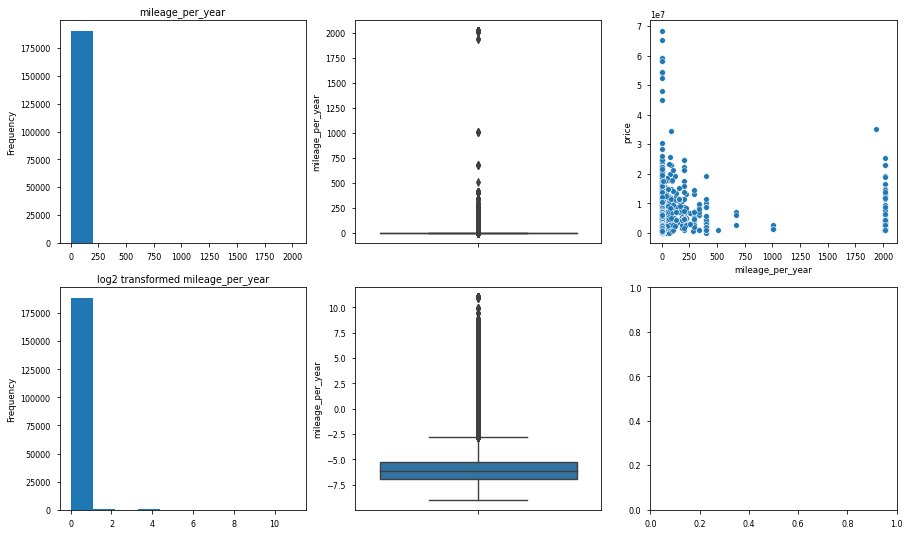

None

,left,right
borders,-0.02578,0.073606
# outliers,0.00000,21459.000000



----------



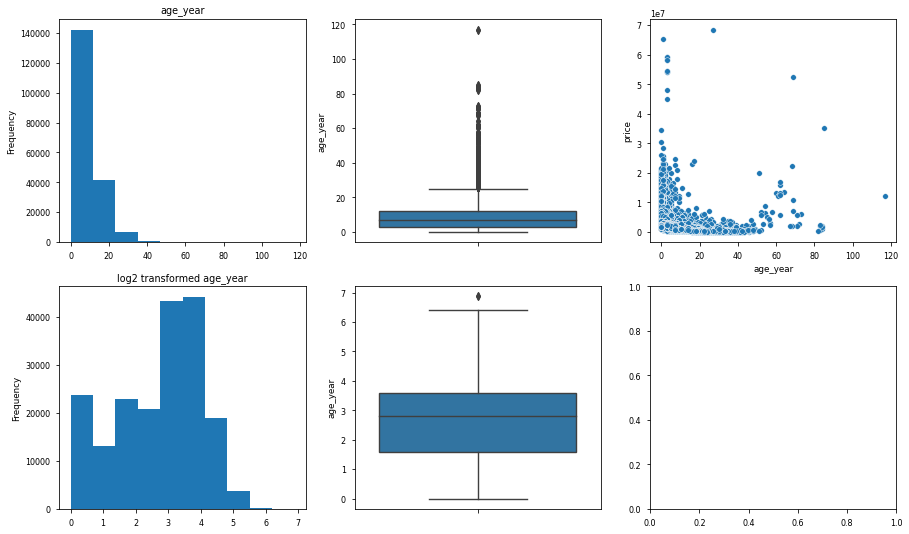

None

,left,right
borders,-0.55066,6.251099
# outliers,0.00000,15.000000



----------



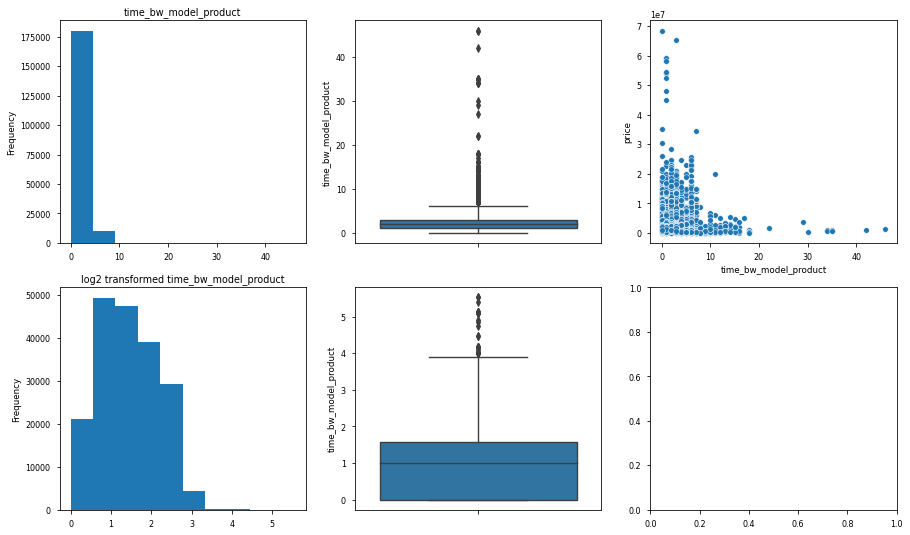

None

,left,right
borders,-0.5,3.5
# outliers,0.0,228.0



----------



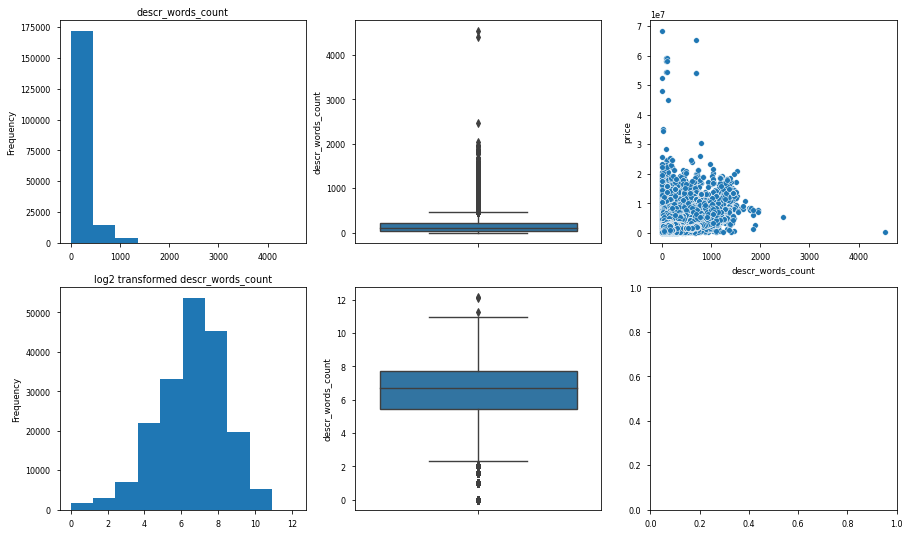

None

,left,right
borders,2.127568,11.098994
# outliers,3370.000000,3.000000



----------



In [146]:
for each in num_cols_added:
    display(vis_num_feature(combined_df, each, 'price', 'train == 1'))
    display(calculate_stat_outliers(combined_df, each, log=True))
    print('\n' + '-' * 10 + '\n')

In [147]:
combined_df['age_year_log2'] = np.log2(combined_df.age_year+1)
# combined_df['age_year_log2'].replace([np.inf, -np.inf], 0, inplace=True)
combined_df['time_bw_model_product_log2'] = np.log2(combined_df.time_bw_model_product+1)
# combined_df['descr_words_count_log2'] = np.log2(combined_df.descr_words_count+1)

combined_df['mileage_per_year_log2'] = np.log2(combined_df.mileage_per_year+1)
# combined_df['mileage_per_year_log2'].replace([np.inf, -np.inf], 0, inplace=True)

In [148]:
num_cols_added.remove('age_year')
num_cols_added.remove('mileage_per_year')
num_cols_added.remove('time_bw_model_product')

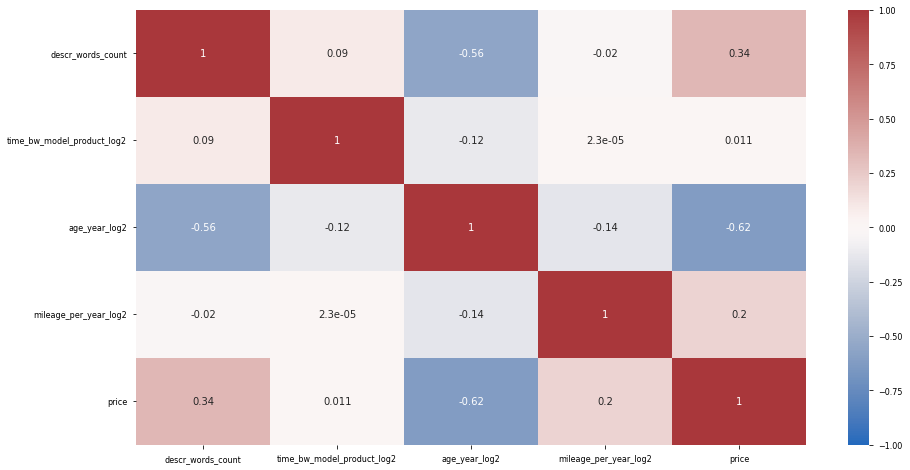

In [149]:
plt.figure(figsize=(15, 8));
sns.heatmap(combined_df[combined_df.train == 1][num_cols_added + ['time_bw_model_product_log2',
    'age_year_log2', 'mileage_per_year_log2', 
    'price']].corr(), vmin=-1, vmax=1, annot=True, cmap='vlag');

It's clear that the log2-transformed columns have closer to the normal distribution and have higher positive or negative correlation with the target variable. Let's leave these columns log2-transformed.

In [150]:
num_cols_added.extend(['time_bw_model_product_log2', 'age_year_log2', 'mileage_per_year_log2'])

### - binary columns

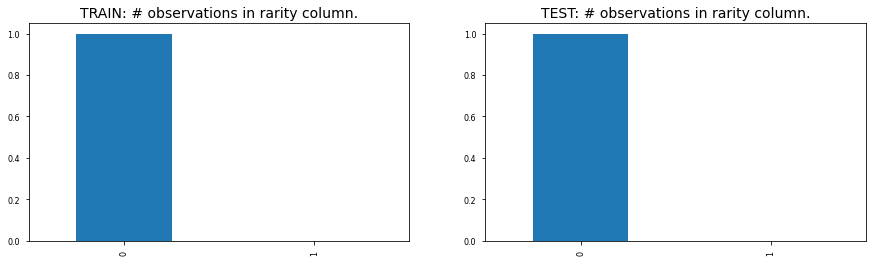

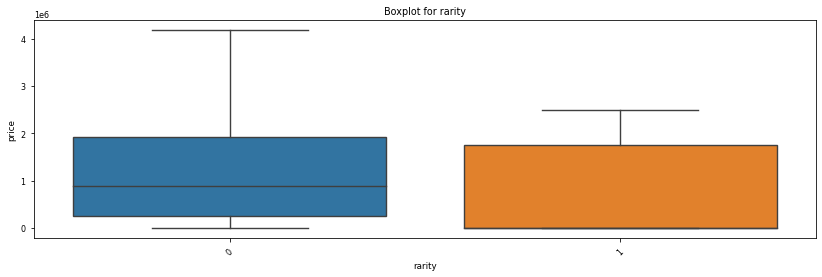

______________________________________________________________________________________________________________________________________________________




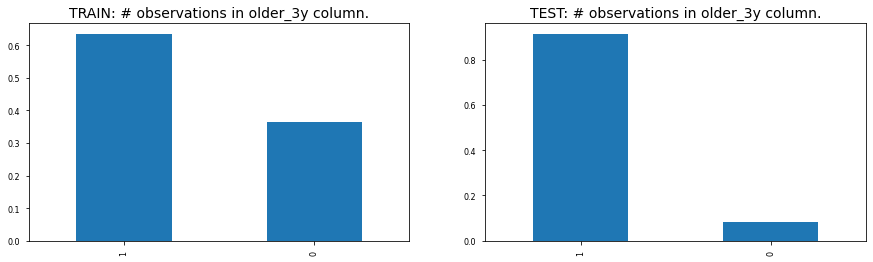

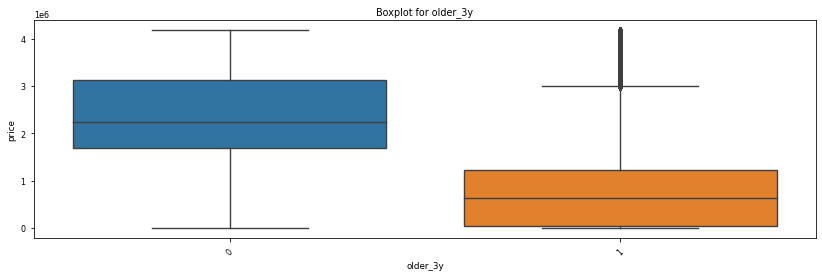

______________________________________________________________________________________________________________________________________________________




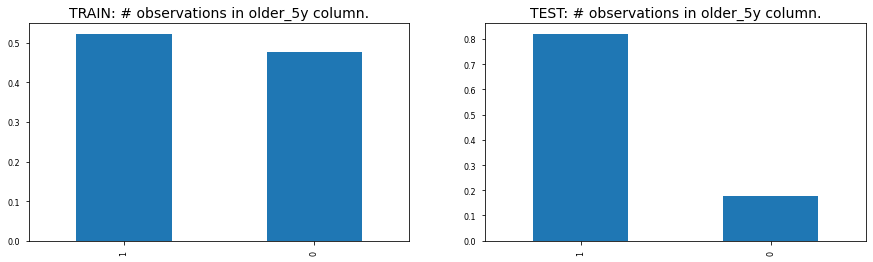

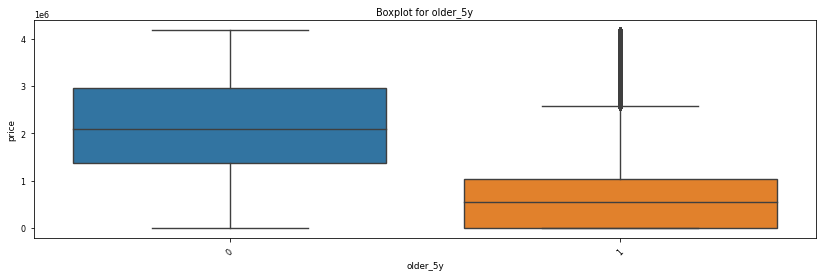

______________________________________________________________________________________________________________________________________________________




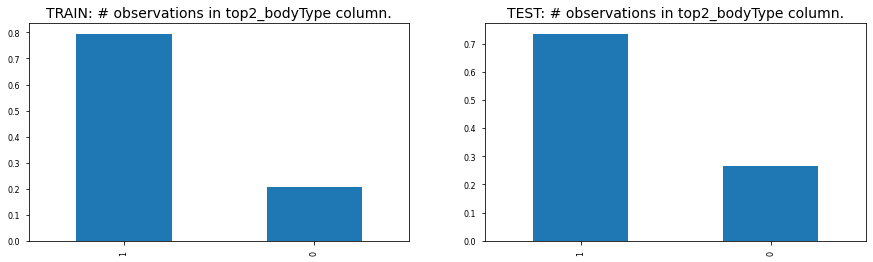

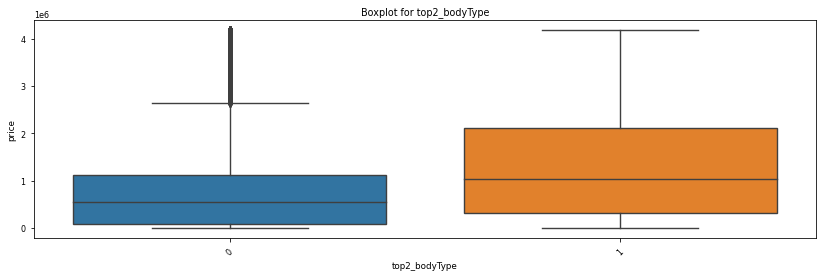

______________________________________________________________________________________________________________________________________________________




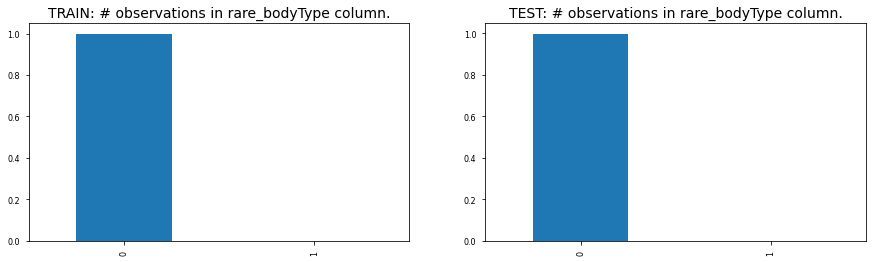

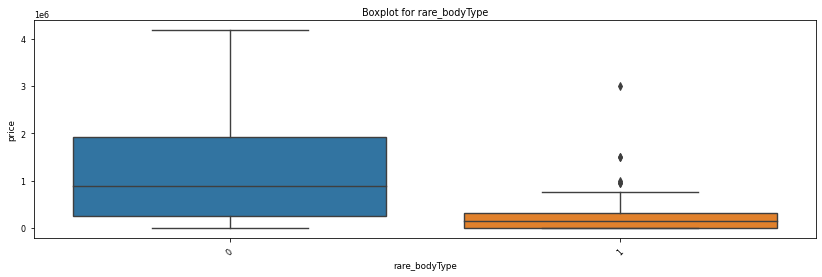

______________________________________________________________________________________________________________________________________________________




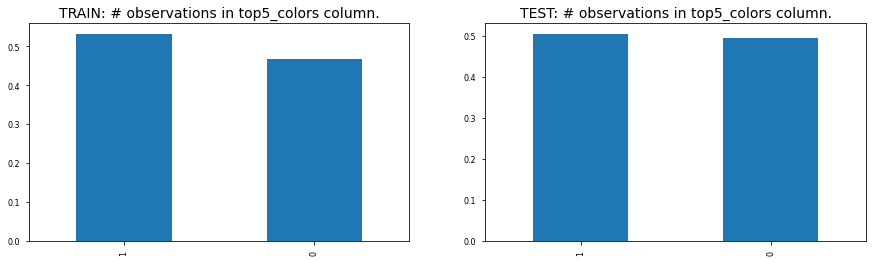

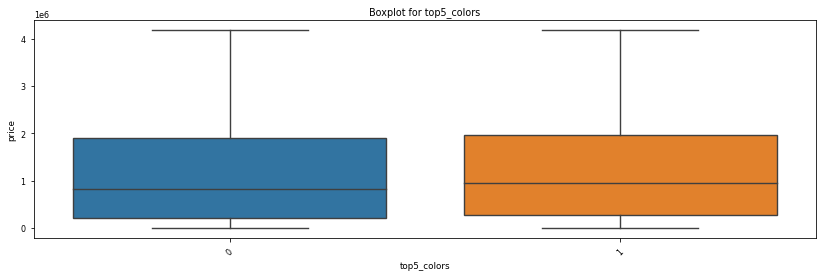

______________________________________________________________________________________________________________________________________________________




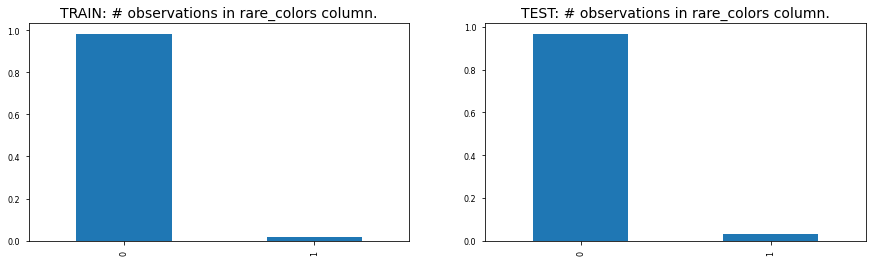

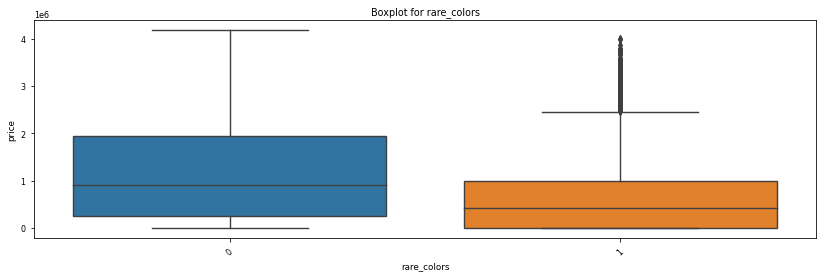

______________________________________________________________________________________________________________________________________________________




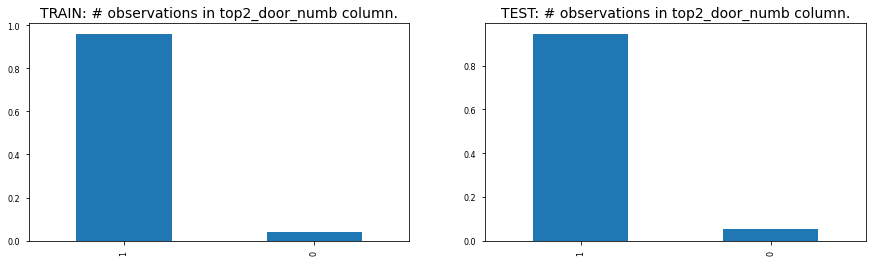

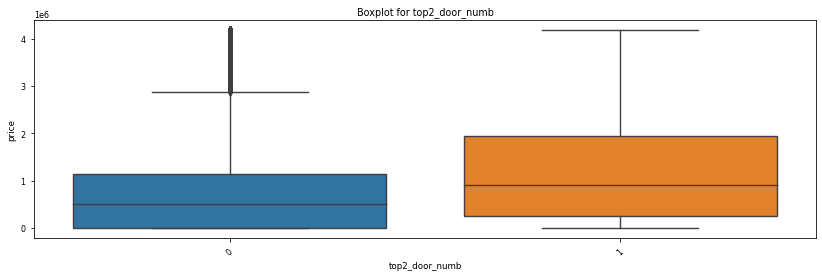

______________________________________________________________________________________________________________________________________________________




In [151]:
for col in bin_cols_added:
    fig, ax = plt.subplots(figsize=(15, 4), ncols=2, nrows=1)
    ax[0].set_title(f'TRAIN: # observations in {col} column.', fontdict={'fontsize': 14})
    combined_df[combined_df.train == 1][col].value_counts(normalize=True).plot(kind='bar', ax=ax[0])
    ax[1].set_title(f'TEST: # observations in {col} column.', fontdict={'fontsize': 14})
    combined_df[combined_df.train == 0][col].value_counts(normalize=True).plot(kind='bar', ax=ax[1])
    # to visualize the boxplots for the price that has a lot of outliers we'll use 90% quantile for the price
    show_boxplot(data=combined_df[combined_df.price <= combined_df.price.quantile(0.9)], column=col, target_column='price')
    print('_' * 150)
    print('\n')
    plt.show()

Based on the plots we could conclude that all variable can be useful for the model.

## Construct final lists of all columns

In [152]:
combined_df.drop(cols_to_remove, axis=1, inplace=True)

In [153]:
num_cols.extend(num_cols_added)
bin_cols.extend(bin_cols_added)

In [154]:
num_cols, bin_cols, cat_cols

(['enginePower',
  'mileage',
  'productionDate',
  'descr_words_count',
  'time_bw_model_product_log2',
  'age_year_log2',
  'mileage_per_year_log2'],
 ['condition',
  'customs',
  'steering_wheel',
  'vehicleTransmission',
  'vendor',
  'vehicle_licence',
  'rarity',
  'older_3y',
  'older_5y',
  'top2_bodyType',
  'rare_bodyType',
  'top5_colors',
  'rare_colors',
  'top2_door_numb'],
 ['bodyType',
  'brand',
  'color',
  'fuelType',
  'model_name',
  'name',
  'driving_gear',
  'owners',
  'numberOfDoors'])

In [155]:
num_cols.remove('age_year_log2')

In [156]:
#let's log2-transform all other left numerical columns - in this case we get the highest correlation between added values
combined_df['enginePower_log2'] = np.log2(combined_df.enginePower+1)
combined_df['enginePower_log2'].replace([np.inf, -np.inf], 0, inplace=True)
combined_df['mileage_log2'] = np.log2(combined_df.mileage+1)
combined_df['mileage_log2'].replace([np.inf, -np.inf], 0, inplace=True)
# combined_df['productionDate_log2'] = np.log2(combined_df.productionDate)
# combined_df['productionDate_log2'].replace([np.inf, -np.inf], 0, inplace=True)

> before here

In [157]:
num_cols

['enginePower',
 'mileage',
 'productionDate',
 'descr_words_count',
 'time_bw_model_product_log2',
 'mileage_per_year_log2']

In [158]:
num_cols.remove('enginePower')
num_cols.remove('productionDate')

In [159]:
combined_df.drop(['mileage_log2', 'enginePower', 'age_year_log2', 'productionDate'], axis=1, inplace=True)

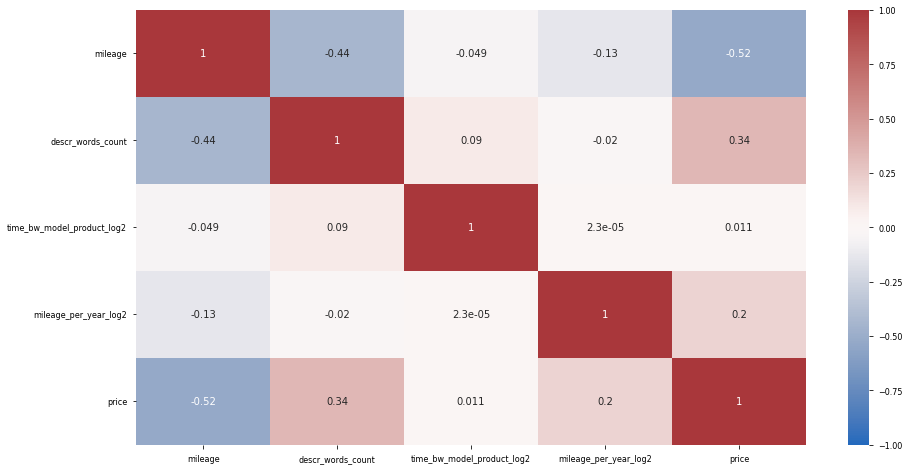

In [160]:
plt.figure(figsize=(15, 8));
sns.heatmap(combined_df[combined_df.train == 1][num_cols + ['price']].corr(), vmin=-1, vmax=1, annot=True, cmap='vlag');

Let's evaluate the importance of numerical values by performing univariate feature selection. Univariate feature selection works by selecting the best features based on univariate statistical tests.

In [161]:
combined_df.dropna(inplace=True)

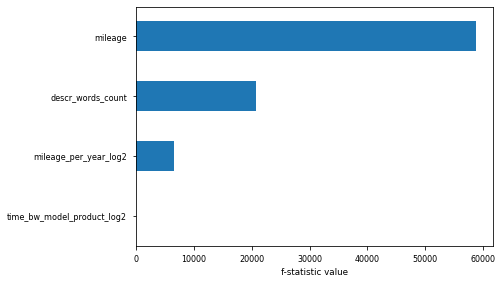

In [162]:
imp_num = pd.Series(f_regression(combined_df[combined_df.train == 1][num_cols], combined_df[combined_df.train == 1]['price'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
plt.xlabel('f-statistic value');

The most import column is meleage that is quite expected.

In [163]:
# labels encoding for all categorical and binary columns
# tried to use OneHotEncoding. The results of the MAPE metrics was not improved. Decided to use the labels encoding for all categorical and binary columns
for colum in ['steering_wheel', 'vehicleTransmission', 'vendor', 'vehicle_licence']:
    combined_df[colum] = combined_df[colum].astype('category').cat.codes

cols_to_encode = list(set(combined_df.columns) & set(cat_cols))
for colum in cols_to_encode:
    combined_df[colum] = combined_df[colum].astype('category').cat.codes

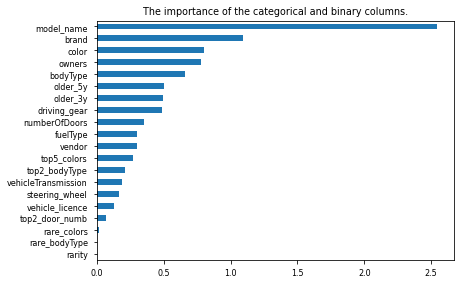

In [164]:
# let's look at the importance of the categorical and binary columns
imp_cat = pd.Series(
    mutual_info_regression(
        combined_df[combined_df.train == 1][list(set(combined_df.columns) & set(cat_cols+bin_cols))], 
        combined_df[combined_df.train == 1]['price'], 
        discrete_features=True), index=list(set(combined_df.columns) & set(cat_cols+bin_cols))
)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh', title='The importance of the categorical and binary columns.')
plt.show()

The top5 most important features are: `model_name`, `brand`, `color`, `owners` and `bodyType`.

# 4.0. Machine learning

In [165]:
X = combined_df.query('train == 1').drop(['price', 'train', 'parsing_date', 'price_log2', 'price_EURO'
                                         ], axis=1)
X_sub = combined_df.query('train == 0').drop(['price', 'train', 'parsing_date', 'price_log2', 'price_EURO'
                                             ], axis=1)
y = combined_df.query('train == 1').price

### Train Split

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

# # Model 1: A naive ML model
![](https://i.pinimg.com/originals/d9/e2/69/d9e269ac226808cafc6bd0b1a98c6403.jpg)  

This model will predict the average price by mileage. Other models can be compared with this naive one.

In [167]:
# tmp_train = X_train.copy()
# tmp_train['price'] = y_train

In [168]:
# predict = X_test['mileage'].map(tmp_train.groupby('mileage')['price'].median())
# print(f"The accuracy of the naive model using MAPE metrics is : {(mape(y_test, predict.values))*100:0.2f}%.")

The accuracy of the naive model using MAPE metric is: 62.95%.

# # Model 2 : CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


Almost all attributes in our data are categorical. Especially for work with such data was created very convenient library CatBoost from Yandex. [https://catboost.ai](http://).     
Right now **CatBoost is one of the best libraries for tabular data!

#### Useful videos about CatBoost (in Russian):
* [CatBoost report](https://youtu.be/9ZrfErvm97M)
* [Fresh Tutorial from the CatBoost team (practical part)](https://youtu.be/wQt4kgAOgV0) 

In [169]:
# cat_boost = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )

# skf = KFold(n_splits=4, random_state=RANDOM_SEED)
# cat_boost_mape_values = []

# for train_index, test_index in skf.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
#     y_train, y_test = y[y.index.isin(train_index)], y[y.index.isin(test_index)]
    
#     # For training, fit() is used
#     cat_boost.fit(X_train, y_train,
#          #cat_features=cat_features_ids,
#          eval_set=(X_test, y_test),
#          verbose_eval=0,
#          use_best_model=True,
#          #plot=True
#          )

#     # For MAPE metric (or any other), we need the predictions of the model
#     y_pred = cat_boost.predict(X_test)

# #     print(mean_squared_error(y_test, y_pred))
# #     print(r2_score(y_test, y_pred))
#     cat_boost_mape_value = mape(y_test, y_pred)
#     cat_boost_mape_values.append(cat_boost_mape_value)
#     print(cat_boost_mape_value)

# print(f"The MAPE mertic for the default CatBoost model using 4-fold CV is: {(np.mean(cat_boost_mape_values) * 100):0.2f}%.")

This MAPE metric is 17.88% and on the leaderboard is 13.21%. 

### Log Traget

In [170]:
# cat_boost_log = CatBoostRegressor(iterations = 5000,
#                           random_seed = RANDOM_SEED,
#                           eval_metric='MAPE',
#                           custom_metric=['R2', 'MAE'],
#                           silent=True,
#                          )

# skf = KFold(n_splits=4, random_state=RANDOM_SEED)
# cat_boost_log_mape_values = []

# for train_index, test_index in skf.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
#     y_train, y_test = y[y.index.isin(train_index)], y[y.index.isin(test_index)]
    
#     # For training, fit() is used
#     cat_boost_log.fit(X_train, np.log(y_train),
#          #cat_features=cat_features_ids,
#          eval_set=(X_test, np.log(y_test)),
#          verbose_eval=0,
#          use_best_model=True,
#          #plot=True
#          )

#     # For MAPE metric (or any other), we need the predictions of the model
#     y_pred = np.exp(cat_boost_log.predict(X_test))

# #     print(mean_squared_error(y_test, y_pred))
# #     print(r2_score(y_test, y_pred))
#     cat_boost_log_mape_value = mape(y_test, y_pred)
#     cat_boost_log_mape_values.append(cat_boost_log_mape_value)
#     print(cat_boost_log_mape_value)

# print(f"The MAPE mertic for the default CatBoost model using 4-fold CV is : {(np.mean(cat_boost_log_mape_values) * 100):0.2f}%.")

This MAPE metric is 14.19% and on the leaderboard is 12.82%. 

# # Model 3 : Random Forest
![](https://i.guim.co.uk/img/media/d143e03bccd1150ef52b8b6abd7f3e46885ea1b3/0_182_5472_3283/master/5472.jpg?width=1200&quality=85&auto=format&fit=max&s=d5a74a011c3fef1ad9c1c962721d221d)

Let's try with the basic RF model with default hyperparameters.

In [171]:
# without log-transformation of the target variable
# rf = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
# rf.fit(X_train, y_train)
# predict_rf = rf.predict(X_test)

# print(f"The MAPE mertics of the Random Forest model using MAPE metrics: {(mape(y_test, predict_rf) * 100):0.2f}%.")

# # with log-transformation of the target variable
# rf_log = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
# rf_log.fit(X_train, np.log(y_train))
# predict_rf_log = np.exp(rf_log.predict(X_test))

# print(f"The MAPE mertic for the Random Forest model is : {(mape(y_test, predict_rf_log) * 100):0.2f}%.")

The MAPE metric on Kaggle is 11.863%. And that's a really big difference with the result that we get - 6.42%. There could be several explanations, e.g. overfitting.
Let's try to use the k-fold cross-validation.

In [172]:
# model = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)

# skf = KFold(n_splits=4, random_state=RANDOM_SEED)
# mape_values = []

# for train_index, test_index in skf.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
#     y_train, y_test = y[y.index.isin(train_index)], y[y.index.isin(test_index)]
    
#     # For training, fit() is used
#     model.fit(X_train, np.log(y_train))

#     # For MAPE metric (or any other), we need the predictions of the model
#     y_pred = np.exp(model.predict(X_test))

# #     print(mean_squared_error(y_test, y_pred))
# #     print(r2_score(y_test, y_pred))
#     mape_value = mape(y_test, y_pred)
#     mape_values.append(mape_value)
#     print(mape_value)

# print(f"The MAPE mertics for the default Random Forest model using 4-fold CV is : {(np.mean(mape_values) * 100):0.2f}%.")

Now the MAPE metric is 17.37% and on the leaderboard is 11.31%.  
The results on the default model are already quite nice, but let's try to optimize the hyperparameters. As a practice, we'll use the `hyperopt` advanced hyperparameter optimization method that helps to obtain the best parameters for a given model.

In [173]:
# hp.uniform('n_estimators',100,500),
# hp.choice("n_estimators", [int(x) for x in np.linspace(200, 1000, num = 17)])

# def objective(params):
#     model=RandomForestRegressor(
#         n_estimators=int(params['n_estimators']),
#         max_depth=int(params['max_depth']),
#         min_samples_leaf=int(params['min_samples_leaf']),
#         min_samples_split=int(params['min_samples_split']),
#         bootstrap=params['bootstrap'],
#         max_features=params['max_features'],
#         random_state=RANDOM_SEED,
#         n_jobs=-1
#     )
#     model.fit(X_train, np.log(y_train))
#     pred=model.predict(X_test)
#     score=mape(y_test,np.exp(pred))
#     return score

# def optimize(trial):
#     params={
#         'n_estimators': hp.uniform('n_estimators',100,500),
#         'max_features': hp.choice("max_features", ['auto', 'sqrt']),
#         'max_depth': hp.uniform('max_depth',5,15),
#         'min_samples_split': hp.uniform('min_samples_split',2,10),
#         'min_samples_leaf': hp.uniform('min_samples_leaf',1,5),
#         'bootstrap': hp.choice("bootstrap", [True, False])
#     }
#     best=fmin(fn=objective, space=params, algo=tpe.suggest, trials=trial, max_evals=100, rstate=np.random.RandomState(RANDOM_SEED))
#     return best

# trial=Trials()
# best=optimize(trial)
# print(best)

The output: 

100%|████████████████████████████████████████████████████████████████| 100/100 [21:49<00:00, 13.09s/trial, best loss: 0.07103610618565381]
{'bootstrap': 0, 'max_depth': 14.934436737745148, 'max_features': 0, 'min_samples_leaf': 2.884056440272862, 'min_samples_split': 7.701088338517911, 'n_estimators': 250.21497714272903}

Let's build a new RFR model with the optimized hyperparameters.

In [174]:
# # with log-transformation of the target variable
# rf_opt_log = RandomForestRegressor(random_state=RANDOM_SEED, 
#                                    n_jobs=-1, 
#                                    verbose=1, 
#                                    n_estimators = 250, 
#                                    min_samples_split = 8, 
#                                    min_samples_leaf = 3, 
#                                    max_features = 'auto', 
#                                    max_depth = 15, 
#                                    bootstrap = True)

# rf_opt_mape_values = []
# skf = KFold(n_splits=4, random_state=RANDOM_SEED)

# for train_index, test_index in skf.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
#     y_train, y_test = y[y.index.isin(train_index)], y[y.index.isin(test_index)]
    
#     # For training, fit() is used
#     rf_opt_log.fit(X_train, np.log(y_train))

#     # For MAPE metric (or any other), we need the predictions of the model
#     y_pred = np.exp(rf_opt_log.predict(X_test))

# #     print(mean_squared_error(y_test, y_pred))
# #     print(r2_score(y_test, y_pred))
#     rf_opt_mape_value = mape(y_test, y_pred)
#     rf_opt_mape_values.append(rf_opt_mape_value)
#     print(rf_opt_mape_value)

# print(f"The MAPE mertic for the optimized Random Forest model using 4-fold CV is : {(np.mean(rf_opt_mape_values) * 100):0.2f}%.")

The MAPE mertic is lower than for the default model - 17.53%. LB result: 13.60814%. The hyperparameters tuning hasn't shown the improvements in the model metrics.

In [175]:
# # in the RFR there is an option to visualize the features' importance for the model 
# plt.rcParams['figure.figsize'] = (10,10)
# feat_importances = pd.Series(rf_opt_log.feature_importances_, index=X.columns)
# feat_importances.nlargest(15).plot(kind='barh')

On several models we see that the results are better with the log-transformed target variable. Let's use it in all other models only log-transformed.

# # Model 4 : ExtraTreesRegressor
![](https://miro.medium.com/max/640/0*4VpGqWJUJnmD2mm0.jpg)

In [176]:
# with log-transformation of the target variable
etr_log = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)

skf = KFold(n_splits=4, random_state=RANDOM_SEED)
etr_log_mape_values = []

for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
    y_train, y_test = y[y.index.isin(train_index)], y[y.index.isin(test_index)]
    
    # For training, fit() is used
    etr_log.fit(X_train, np.log(y_train))

    # For MAPE metric (or any other), we need the predictions of the model
    y_pred = np.exp(etr_log.predict(X_test))

#     print(mean_squared_error(y_test, y_pred))
#     print(r2_score(y_test, y_pred))
    etr_log_mape_value = mape(y_test, y_pred)
    etr_log_mape_values.append(etr_log_mape_value)
    print(etr_log_mape_value)

print(f"The MAPE mertic for the default ExtraTreesRegressor model using 4-fold CV is: {(np.mean(etr_log_mape_values) * 100):0.2f}%.")

ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.

The MAPE metrics in the notebook: 16.48%, on the leaderboard the best submission: 9.66%. 

In [ ]:
# hp.uniform('n_estimators',100,500),
# hp.choice("n_estimators", [int(x) for x in np.linspace(200, 1000, num = 17)])

# def objective(params):
#     model=ExtraTreesRegressor(
#         n_estimators=int(params['n_estimators']),
#         max_depth=int(params['max_depth']),
#         min_samples_leaf=int(params['min_samples_leaf']),
#         min_samples_split=int(params['min_samples_split']),
#         bootstrap=params['bootstrap'],
#         max_features=params['max_features'],
#         random_state=RANDOM_SEED,
#         n_jobs=-1
#     )
#     model.fit(X_train, np.log(y_train))
#     pred=model.predict(X_test)
#     score=mape(y_test,np.exp(pred))
#     return score

# def optimize(trial):
#     params={
#         'n_estimators': hp.uniform('n_estimators',100,500),
#         'max_features': hp.choice("max_features", ['auto', 'sqrt']),
#         'max_depth': hp.uniform('max_depth',5,15),
#         'min_samples_split': hp.uniform('min_samples_split',2,10),
#         'min_samples_leaf': hp.uniform('min_samples_leaf',1,5),
#         'bootstrap': hp.choice("bootstrap", [True, False])
#     }
#     best=fmin(fn=objective, space=params, algo=tpe.suggest, trials=trial, max_evals=100, rstate=np.random.RandomState(RANDOM_SEED))
#     return best

# trial=Trials()
# best=optimize(trial)

The output:

100%|████████████████████████████████████████████████████████████████| 100/100 [15:34<00:00,  9.35s/trial, best loss: 0.07921314865515763]
{'bootstrap': 1, 'max_depth': 14.611090900165628, 'max_features': 0, 'min_samples_leaf': 2.872679970184805, 'min_samples_split': 4.514311914203175, 'n_estimators': 430.8962602244797}

In [ ]:
# # with log-transformation of the target variable and the cross validation
# etr_log_opt = ExtraTreesRegressor(random_state=RANDOM_SEED, 
#                                    n_jobs=-1, 
#                                    verbose=1, 
#                                    n_estimators = 430, 
#                                    min_samples_split = 5, 
#                                    min_samples_leaf = 3, 
#                                    max_features = 'auto', 
#                                    max_depth = 17, 
#                                    bootstrap = False)

# skf = KFold(n_splits=4, random_state=RANDOM_SEED)
# etr_log_opt_mape_values = []

# for train_index, test_index in skf.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
#     y_train, y_test = y[y.index.isin(train_index)], y[y.index.isin(test_index)]
    
#     # For training, fit() is used
#     etr_log_opt.fit(X_train, np.log(y_train))

#     # For MAPE metric (or any other), we need the predictions of the model
#     y_pred = np.exp(etr_log_opt.predict(X_test))

# #     print(mean_squared_error(y_test, y_pred))
# #     print(r2_score(y_test, y_pred))
#     etr_log_opt_mape_value = mape(y_test, y_pred)
#     etr_log_opt_mape_values.append(etr_log_opt_mape_value)
#     print(etr_log_opt_mape_value)

# print(f"The MAPE mertic for the optimized ExtraTreesRegressor model using 4-fold CV is: {(np.mean(etr_log_opt_mape_values) * 100):0.2f}%.")

The MAPE metrics in the notebook: 16.74%, on the leaderboard: 13.059%. 

In [ ]:
# in the ETR there is an option to visualize the features' importance for the model 
# plt.rcParams['figure.figsize'] = (10,10)
# feat_importances = pd.Series(etr_log_opt.feature_importances_, index=X.columns)
# feat_importances.nlargest(15).plot(kind='barh')

The list of top5 important features for the model:
- owners
- age_year
- mileage
- enginePower_log2
- driving_gear

# # Model 5 : XGBoostRegressor
![](https://cdn3.vectorstock.com/i/1000x1000/74/02/coffee-boost-energy-vector-19917402.jpg)

In [ ]:
# xgb_log = xgb.XGBRegressor(
#     objective='reg:squarederror', 
#     colsample_bytree=0.5,               
#     learning_rate=0.05, 
#     max_depth=12, 
#     alpha=1,                   
#     n_estimators=1000,
#     random_state=RANDOM_SEED,
#     verbose=1, 
#     n_jobs=-1,
# )

# skf = KFold(n_splits=4, random_state=RANDOM_SEED)
# xgb_log_mape_values = []

# for train_index, test_index in skf.split(X, y):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[X.index.isin(train_index)], X[X.index.isin(test_index)]
#     y_train, y_test = y[y.index.isin(train_index)], y[y.index.isin(test_index)]
    
#     # For training, fit() is used
#     xgb_log.fit(X_train, np.log(y_train))

#     # For MAPE metric (or any other), we need the predictions of the model
#     y_pred = np.exp(xgb_log.predict(X_test))

# #     print(mean_squared_error(y_test, y_pred))
# #     print(r2_score(y_test, y_pred))
#     xgb_log_mape_value = mape(y_test, y_pred)
#     xgb_log_mape_values.append(xgb_log_mape_value)
#     print(xgb_log_mape_value)

# print(f"The MAPE mertic for the XGBRegressor model using 4-fold CV: {(np.mean(xgb_log_mape_values) * 100):0.2f}%.")

The MAPE metric in the notebook is: 14.78%, on the leaderboard: 10.75%. 

In [ ]:
# xgb.plot_importance(xgb_log)
# plt.show()

It's quite interesting that XBR has different pattern in the feature importances. Here top5 features are:
- descr_words_count
- mileage
- mileage_per_year
- enginePower_log2
- model_name

# # Model 6 : StackingRegressor
![](https://www.treehugger.com/thmb/MPyNjODcEJqfxa9B_PO4r-B41D4=/887x665/smart/filters:no_upscale()/__opt__aboutcom__coeus__resources__content_migration__mnn__images__2018__08__Stacking-rocks-beach-cairns-ca8fcb6c081d40409bf960865c2315b5.jpg)

Here it's intesting to try to stack the models that have demostrated the best results: ExtraTreeRegressor and XGBRegressor with the LinearRegression meta model:

In this case the stacking of the model can also improve the metrics value and prevent the overfitting.

In [ ]:
# estimators = [
#     ('etr', ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)),
#     ('xgb', xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5, learning_rate=0.05, max_depth=12, alpha=1, n_jobs=-1, n_estimators=1000, random_state=RANDOM_SEED))
# ]

# sr_log = StackingRegressor(
#     estimators=estimators,
#     final_estimator=LinearRegression()
# )

# # For training, fit() is used
# sr_log.fit(X_train, np.log(y_train))

# # For MAPE metric (or any other), we need the predictions of the model
# y_pred = np.exp(sr_log.predict(X_test))

# print(f"The MAPE mertic for the default StackingRegressor model: {(mape(y_test, y_pred) * 100):0.2f}%.")

The MAPE metric in the notebook is: 15.39%, on the leaderboard: %10.80. 

## Final decision about the model:

The best MAPE metrics on our data on the leaderboard were shown by tree-based (ExtraTreeRegressor: 9.66%) and booster (XGBoostRegressor: 10.75%) models. Stacking of these two models using a LinearRegression meta model showed also quite a high result on the submission - 10.80%. 
As a result, a default ExtraTreeRegressor model was decided to use as a final model for the prediction. (The hyperparameters optimization hasn't gained any improvements.)

# Submission

In [ ]:
predict_submission = np.exp(etr_log.predict(X_sub))
sample_submission['price'] = predict_submission
# sample_submission.to_csv(f'submission_final.csv', index=False)
sample_submission.head(10)

# Summary:
![](https://rgchannel.edu.sg/wp-content/uploads/2018/04/OGMT8M0-1024x694.jpg)




## Work on this project was carried out in several steps:

1. **Data enrichment** (parsing from `auto.ru`):
    - collection of additional relevant data for the training dataset containing **130201** observations;
2. **EDA**:
    - transforming the training and test datasets into a unified form and merging them;
    - cleaning and unification of the data;
    - handling of missing values;
    - handling of duplicates;
    - analysis of relationship between features (numerical, categorical, binary) and between the features and the target;
    - outlier analysis;
3. **Feature engineering**:
    - 4 numerical and 8 binary columns were added to the data and used for the final submission of the project to improve the MAPE metric. Additional columns (3 columns and polynomial features) were added during the development phase, but they did not improve the model, so they were removed for the final submission;
4. **ML**:
    - all binary and categorical data are encoded in the final model as labels as the hot-encoding method did not yield any improvements of the MAPE metric;
    - standartization was not used as it yielded no improvements;
    - 5 different ML models were tested: CatBoost, RandomForest, ExtraTrees, XGBoost and Stacking. For the RandomForest and ExtraTrees models the hyperparameters tuning was performed using hyperopt library but it didn't improve the result.

## Results:
The best MAPE metrics in the leaderboard were shown by the tree-based (ExtraTreeRegressor: 9.66%) and the booster (XGBoostRegressor: 10.75%) models. The stacking of these two models using a LinearRegression meta model showed also quite a high result on the submission - 10.80%. As a result, I decided to use the default ExtraTreeRegressor model as a final prediction model.

The proposed solution is ranked **9th** out of 202th on the leaderboard (**MAPE = 9.66%**) (08.10.2021).

## What could be improved:
- additional feature engineering, such as the feature extraction from text (NLP), parsing of new data, etc., could help to improve the MAPE metric;
- other methods to optimize the hyperparameters of the model;
- to run lazypredict library and try to use other high ranked ML models;
- analyse the results of the ML model work and try to understand why there is a difference between the MAPE metric results in the notebook and on the submission.